DeepRitz ML model for solving the monodomain problem 
Using the IMEX time dependend formula 

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F


In [2]:
# n_x, n_y grid size for x and y
# sigma_h, sigma_d conductivity of healthy and diseased regions
# dr, lists of the diseased regions points (x_center, y_center, radius) to fit the (x−0.3)^2 +(y−0.7)^2 <0.1^2 formulas
# returns a 2D array of all the points in the grid with the healthy and diseased regions marked
def cond_map(n_x, n_y, sigma_h, sigma_d, dr):
    x = np.linspace(0, 1, n_x)
    y = np.linspace(0, 1, n_y)
    X, Y = np.meshgrid(x, y, indexing='ij')
    sigma = np.full((n_x, n_y), sigma_h)

    for (xc, yc, r) in dr:
        mask = (X - xc)**2 + (Y - yc)**2 < r**2
        sigma[mask] = sigma_d

    return sigma


Initial condition function

Using device: cpu


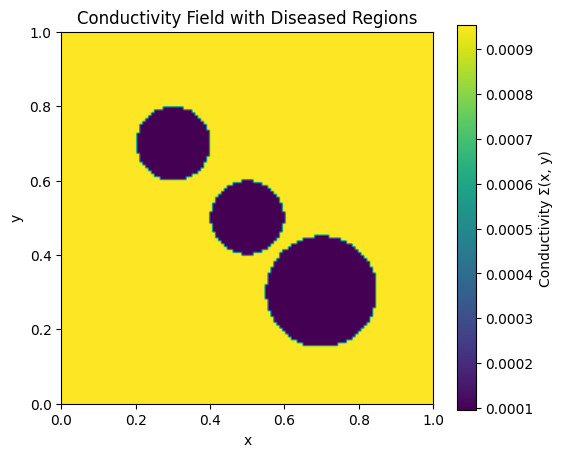

In [3]:
# params
n_x, n_y = 128, 128
dr = [(0.3, 0.7, 0.1), (0.7, 0.3, 0.15), (0.5, 0.5, 0.1)]
sigma_h = 9.5298e-4
# sigma_d = 10 * sigma_h
# sigma_d = sigma_h
sigma_d = 0.1 * sigma_h
a = 18.515
ft = 0.2383
fr = 0
fd = 1
T = 35
sigma = cond_map(n_x, n_y, sigma_h, sigma_d, dr)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
sigma_t = torch.tensor(sigma.flatten(), dtype=torch.float32).to(device)


# heart map values
plt.figure(figsize=(6, 5))
plt.imshow(sigma.T, origin='lower', extent=[0,1,0,1], cmap='viridis')
plt.colorbar(label='Conductivity Σ(x, y)')
plt.title('Conductivity Field with Diseased Regions')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(False)
plt.show()



In [4]:
# u0(x, y) = 1 if x ≥ 0.9 and y ≥ 0.9, else 0.
# returns u0 as a 2D array
def ic(n_x, n_y):
    x = np.linspace(0, 1, n_x)
    y = np.linspace(0, 1, n_y)
    X, Y = np.meshgrid(x, y, indexing='ij')

    u0 = np.zeros((n_x, n_y))
    u0[(X >= 0.9) & (Y >= 0.9)] = 1.0
    return u0

Reaction term

In [5]:
# reaction term 
def R(u, a, fr, ft, fd):
    return a * (u - fr) * (u - ft) * (u - fd)

RHS of the IMEX eq

In [6]:
# RHS = (1/dt) * u^n + f(u^n)
# u_n, solution at time step n
# dt : time step size
# returns a 2D array pf the rhs
def rhs(u_n, a, fr, ft, fd, dt):
    f_un = R(u_n, a, fr, ft, fd)
    return (1.0 / dt) * u_n + f_un

Model 

In [7]:
class DeepRitz(nn.Module):
    def __init__(self, input_dim=2, output_dim=1, w=64, d=4):
        super().__init__()
        self.linear = nn.ModuleList([nn.Linear(w if i>0 else input_dim, w) for i in range(d)])
        self.linearOut = nn.Linear(w, output_dim)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)  
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = F.softplus(self.linear[0](x))
        for layer in self.linear[1:]:
            x_temp = F.softplus(layer(x))
            x = x + x_temp
        return torch.sigmoid(self.linearOut(x))


Sample points

In [8]:
# sample collocation points 

# creates 3 pools, IC, diseased regions, normal points
def sampling_pools(n_x, n_y, disease_mask):
    x = np.linspace(0, 1, n_x)
    y = np.linspace(0, 1, n_y)
    X, Y = np.meshgrid(x, y, indexing='ij')
    coords = np.stack([X.flatten(), Y.flatten()], axis=-1)

    disease_pts = coords[disease_mask.flatten() == 1]
    ic_mask = (coords[:, 0] > 0.9) & (coords[:, 1] > 0.9)
    ic_pts = coords[ic_mask]
    full_pts = coords

    return full_pts, disease_pts, ic_pts

# samples points from the 3 pools, using a multiplier for each pool
def sample_from_pools(full_pts, disease_pts, ic_pts, N, br_ic=0.2, br_disease=0.3):
    n_ic = int(N * br_ic)
    n_disease = int(N * br_disease)
    n_uniform = N - n_ic - n_disease

    idx_full = np.random.choice(len(full_pts), n_uniform, replace=(n_uniform > len(full_pts)))
    idx_disease = np.random.choice(len(disease_pts), n_disease, replace=(n_disease > len(disease_pts)))
    idx_ic = np.random.choice(len(ic_pts), n_ic, replace=(n_ic > len(ic_pts)))

    selected = np.concatenate([
        full_pts[idx_full],
        disease_pts[idx_disease],
        ic_pts[idx_ic]
    ])

    return torch.tensor(selected, dtype=torch.float32)

Energy function

In [9]:
# interpolation functions to allow samplinh at the collocation points
def rhs_norm(points):
    idx_x = (points[:, 0] * (n_x - 1)).long()
    idx_y = (points[:, 1] * (n_y - 1)).long()
    return rhs_t[idx_x * n_y + idx_y].unsqueeze(1)

def sigma_norm(points):
    idx_x = (points[:, 0] * (n_x - 1)).long()
    idx_y = (points[:, 1] * (n_y - 1)).long()
    return sigma_t[idx_x * n_y + idx_y].unsqueeze(1)

# energy function based on the derivation 
def energy_f(model, points, sigma_norm, rhs_norm, dt , u_n):
    points.requires_grad_(True)
    u = model(points).squeeze()
    grad_u = autograd.grad(outputs=u, inputs=points, grad_outputs=torch.ones_like(u), create_graph=True)[0] # ∇u^{n+1}
    sigma_vals = sigma_norm(points).squeeze()        # sigma(x, y)
    rhs_vals = rhs_norm(points).squeeze()            # (1/dt) u^n - f(u^n)
    idx_x = (points[:, 0] * (n_x - 1)).long()
    idx_y = (points[:, 1] * (n_y - 1)).long()
    u_n_interp = u_n[idx_x * n_y + idx_y]

    grad_norm_sq = (grad_u**2).sum(dim=1)            # ||grad(u)||^2

    # M u^(n+1) + dt K u^{n+1} = M u^n - dt f(u^n)
    # where K = 1/2 *sigma * grad^2
    energy = ((0.5 / dt) * (u - u_n_interp)**2 + 0.5 * sigma_vals * grad_norm_sq - rhs_vals * u).mean()
    return energy.mean() 

Training 

In [10]:
# training func
def train(model, points, sigma_norm, rhs_norm, dt, lr, steps, device, ic_target=None, full_grid=None, u_n=None):
    model.train()
    points = points.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in range(steps):
        optimizer.zero_grad()
        loss = energy_f(model, points, sigma_norm, rhs_norm, dt, u_n)
        if ic_target is not None and full_grid is not None:   # to weight gradient loss for reinforcement of it
            model.eval()
            u_pred = model(full_grid).squeeze()
            ic_loss = F.mse_loss(u_pred, ic_target)
            loss += 100* ic_loss  
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % (steps // 10 if steps >= 10 else 1) == 0:
            print(f"    Epoch [{epoch+1}/{steps}], Loss: {loss.item():.8f}")
    
    return model, losses

In [11]:
def stats(model, xy, u_n, sigma_norm, dt, a, fr, ft, fd):
    xy = xy.clone().detach().requires_grad_(True)
    u_pred = model(xy).squeeze()
    grad_u = autograd.grad(u_pred, xy, grad_outputs=torch.ones_like(u_pred),create_graph=True, retain_graph=True)[0]
    sigma_vals = sigma_norm(xy).squeeze()
    flux = sigma_vals.unsqueeze(-1) * grad_u
    div_diff = 0
    for i in range(xy.shape[1]):
        div_flux_i = autograd.grad(
            outputs=flux[:, i],
            inputs=xy,
            grad_outputs=torch.ones_like(flux[:, i]),
            create_graph=True,
            retain_graph=True
        )[0][:, i]
        div_diff += div_flux_i

    idx_x = (xy[:, 0] * (n_x - 1)).long()
    idx_y = (xy[:, 1] * (n_y - 1)).long()
    u_n_vals = u_n[idx_x * n_y + idx_y].to(xy.device)
    f_un = R(u_n_vals, a, fr, ft, fd)
    dt_u_term = (u_pred - u_n_vals) / dt
    residual = dt_u_term - div_diff + f_un

    return {
        'du_dt': dt_u_term.detach().cpu().numpy(),
        'diffusion': (-div_diff).detach().cpu().numpy(),
        'reaction': f_un.detach().cpu().numpy(),
        'residual': residual.detach().cpu().numpy(),
        'grad_u': grad_u.detach().cpu().numpy()
    }

In [12]:
# compute the graddient 
def grad(model, x):
    x.requires_grad_(True) 
    u = model(x) 
    if u.ndim == 2 and u.shape[1] == 1:
        u = u.squeeze(-1)
    grad_u = torch.autograd.grad(outputs=u,inputs=x,grad_outputs=torch.ones_like(u),create_graph=True,retain_graph=True,only_inputs=True)[0]
    return grad_u

In [13]:
# //// param def ////////////////////
dt = 0.5
N = int(T/dt)
steps = 1500
colloc_p = 1024
w = 64 
d = 4
lr = 3e-4  # could get smaller 

deepRM = DeepRitz(input_dim=2, output_dim=1, w=w, d=d).to(device)

# Make binary disease mask from sigma
disease_mask = (sigma < sigma_h).astype(np.uint8)
full_pts, disease_pts, ic_pts = sampling_pools(n_x, n_y, disease_mask)

x = np.linspace(0, 1, n_x)
y = np.linspace(0, 1, n_y)
X, Y = np.meshgrid(x, y, indexing='ij')
xy_coords = np.stack([X.flatten(), Y.flatten()], axis=-1)
xy_t = torch.tensor(xy_coords, dtype=torch.float32).to(device)

u_n = ic(n_x, n_y)
u_n = torch.tensor(u_n.flatten(), dtype=torch.float32)
u_np = u_n.detach().numpy().reshape(n_x, n_y)

rhs_v = rhs(u_np, a, fr, ft, fd, dt).flatten()
rhs_t = torch.tensor(rhs_v, dtype=torch.float32).to(device)

iter: 0 ###############################
    Epoch [150/1500], Loss: 1.04085386
    Epoch [300/1500], Loss: 0.82713366
    Epoch [450/1500], Loss: 0.57484061
    Epoch [600/1500], Loss: 0.46441114
    Epoch [750/1500], Loss: 0.39932394
    Epoch [900/1500], Loss: 0.35534963
    Epoch [1050/1500], Loss: 0.32356170
    Epoch [1200/1500], Loss: 0.30009326
    Epoch [1350/1500], Loss: 0.28260025
    Epoch [1500/1500], Loss: 0.27895966
    Energy after iteration 0: -0.007118


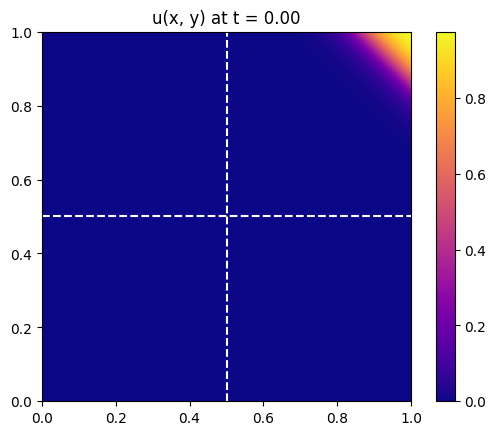

RHS max: 1.6137e+00, min: -4.2982e-01, mean: 9.8812e-03


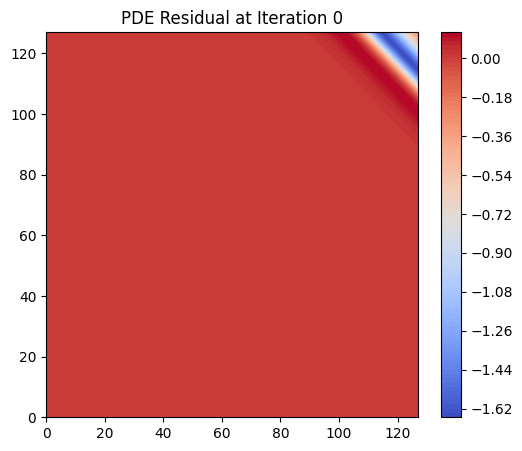

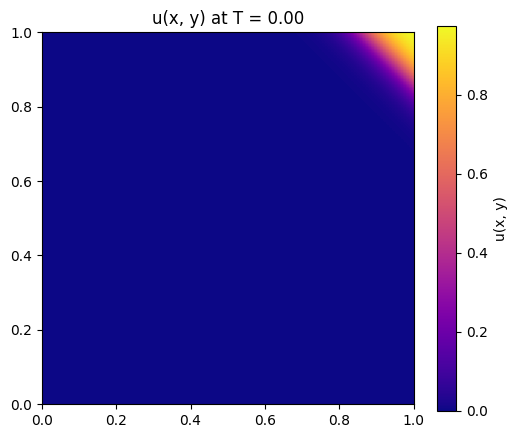

iter: 1 ###############################
    Epoch [150/1500], Loss: -0.01277537
    Epoch [300/1500], Loss: -0.01337826
    Epoch [450/1500], Loss: -0.01360163
    Epoch [600/1500], Loss: -0.01367389
    Epoch [750/1500], Loss: -0.01369796
    Epoch [900/1500], Loss: -0.01366079
    Epoch [1050/1500], Loss: -0.01370803
    Epoch [1200/1500], Loss: -0.01371285
    Epoch [1350/1500], Loss: -0.01363942
    Epoch [1500/1500], Loss: -0.01371508
    Energy after iteration 1: 0.083086


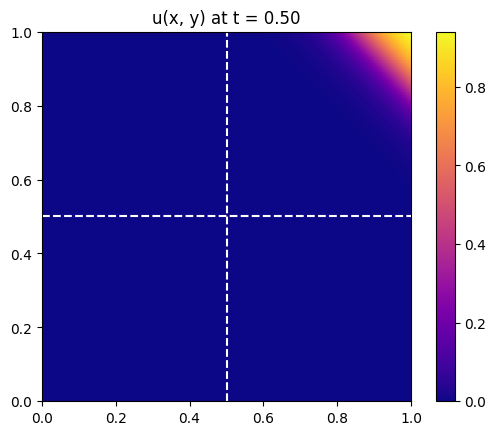

RHS max: 1.1505e+00, min: -4.3424e-01, mean: 1.4246e-02
iter: 2 ###############################
    Epoch [150/1500], Loss: 0.01001942
    Epoch [300/1500], Loss: 0.00974147
    Epoch [450/1500], Loss: 0.00949880
    Epoch [600/1500], Loss: 0.00936861
    Epoch [750/1500], Loss: 0.00932284
    Epoch [900/1500], Loss: 0.00931546
    Epoch [1050/1500], Loss: 0.00932900
    Epoch [1200/1500], Loss: 0.00932221
    Epoch [1350/1500], Loss: 0.00929799
    Epoch [1500/1500], Loss: 0.00948517
    Energy after iteration 2: 0.078919


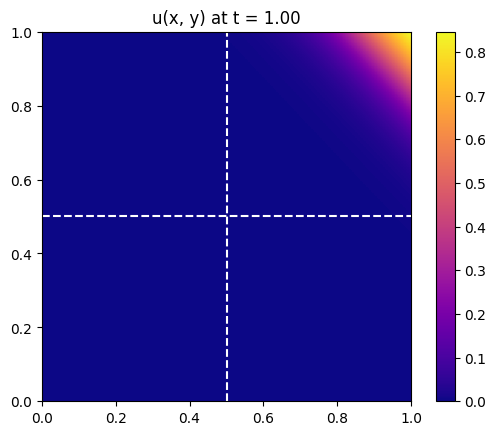

RHS max: 5.1936e-01, min: -4.3425e-01, mean: 2.3757e-02
iter: 3 ###############################
    Epoch [150/1500], Loss: 0.03032454
    Epoch [300/1500], Loss: 0.02940253
    Epoch [450/1500], Loss: 0.02858885
    Epoch [600/1500], Loss: 0.02810766
    Epoch [750/1500], Loss: 0.02798496
    Epoch [900/1500], Loss: 0.02797336
    Epoch [1050/1500], Loss: 0.02796554
    Epoch [1200/1500], Loss: 0.02796105
    Epoch [1350/1500], Loss: 0.02795910
    Epoch [1500/1500], Loss: 0.02795482
    Energy after iteration 3: 0.070517


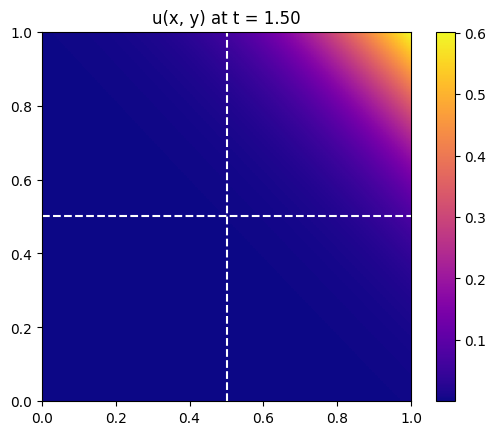

RHS max: 5.1936e-01, min: -4.0946e-01, mean: 8.7701e-02
iter: 4 ###############################
    Epoch [150/1500], Loss: 0.00610015
    Epoch [300/1500], Loss: 0.00577504
    Epoch [450/1500], Loss: 0.00543485
    Epoch [600/1500], Loss: 0.00496587
    Epoch [750/1500], Loss: 0.00459269
    Epoch [900/1500], Loss: 0.00444535
    Epoch [1050/1500], Loss: 0.00438042
    Epoch [1200/1500], Loss: 0.00435992
    Epoch [1350/1500], Loss: 0.00435291
    Epoch [1500/1500], Loss: 0.00435051
    Energy after iteration 4: 0.042295


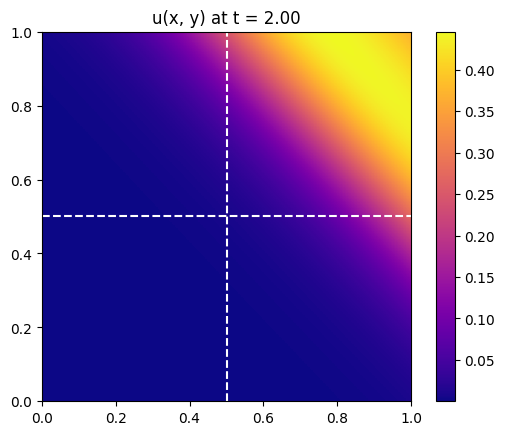

RHS max: 5.1936e-01, min: -5.8102e-02, mean: 1.2266e-01
iter: 5 ###############################
    Epoch [150/1500], Loss: -0.01393370
    Epoch [300/1500], Loss: -0.01399162
    Epoch [450/1500], Loss: -0.01401959
    Epoch [600/1500], Loss: -0.01403726
    Epoch [750/1500], Loss: -0.01377578
    Epoch [900/1500], Loss: -0.01405940
    Epoch [1050/1500], Loss: -0.01406860
    Epoch [1200/1500], Loss: -0.01406975
    Epoch [1350/1500], Loss: -0.01407391
    Epoch [1500/1500], Loss: -0.01408825
    Energy after iteration 5: 0.036345


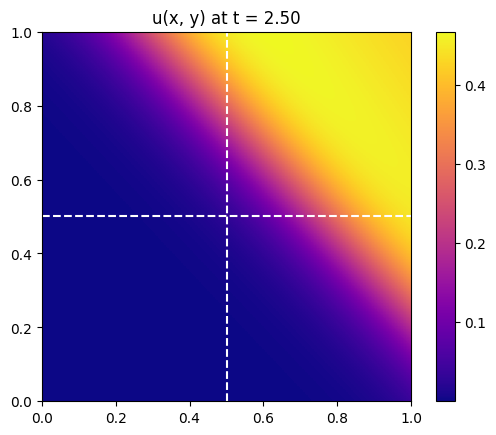

RHS max: 5.1936e-01, min: -1.2112e-01, mean: 1.1866e-01
iter: 6 ###############################
    Epoch [150/1500], Loss: -0.01941250
    Epoch [300/1500], Loss: -0.01946463
    Epoch [450/1500], Loss: -0.01950511
    Epoch [600/1500], Loss: -0.01951703
    Epoch [750/1500], Loss: -0.01946198
    Epoch [900/1500], Loss: -0.01951335
    Epoch [1050/1500], Loss: -0.01950202
    Epoch [1200/1500], Loss: -0.01956581
    Epoch [1350/1500], Loss: -0.01957323
    Epoch [1500/1500], Loss: -0.01955075
    Energy after iteration 6: 0.042330


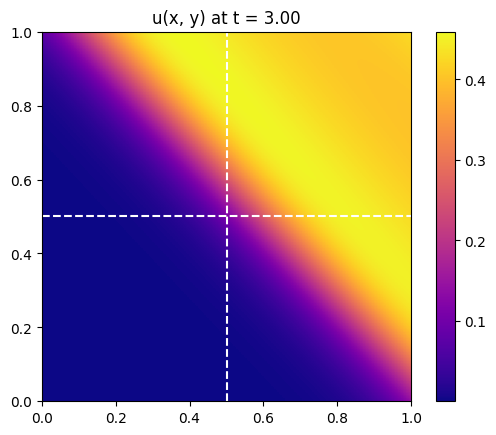

RHS max: 5.1936e-01, min: -9.7676e-02, mean: 1.1256e-01
iter: 7 ###############################
    Epoch [150/1500], Loss: -0.05799954
    Epoch [300/1500], Loss: -0.05807213
    Epoch [450/1500], Loss: -0.05802859
    Epoch [600/1500], Loss: -0.05817911
    Epoch [750/1500], Loss: -0.05821584
    Epoch [900/1500], Loss: -0.05823823
    Epoch [1050/1500], Loss: -0.05826504
    Epoch [1200/1500], Loss: -0.05828191
    Epoch [1350/1500], Loss: -0.05790628
    Epoch [1500/1500], Loss: -0.05807322
    Energy after iteration 7: 0.041852


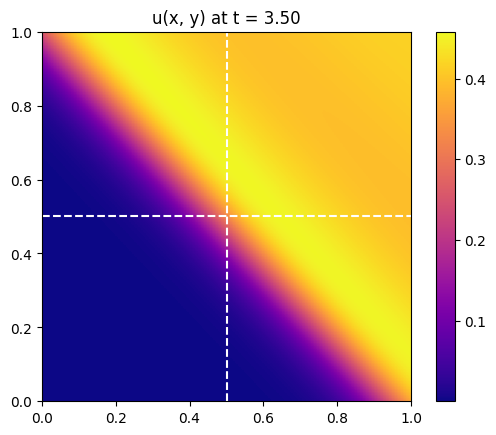

RHS max: 5.1936e-01, min: -9.4532e-02, mean: 9.5887e-02
iter: 8 ###############################
    Epoch [150/1500], Loss: -0.04693094
    Epoch [300/1500], Loss: -0.04699385
    Epoch [450/1500], Loss: -0.04680391
    Epoch [600/1500], Loss: -0.04710547
    Epoch [750/1500], Loss: -0.04716437
    Epoch [900/1500], Loss: -0.04719104
    Epoch [1050/1500], Loss: -0.04718480
    Epoch [1200/1500], Loss: -0.04712410
    Epoch [1350/1500], Loss: -0.04725599
    Epoch [1500/1500], Loss: -0.04725525
    Energy after iteration 8: 0.102229


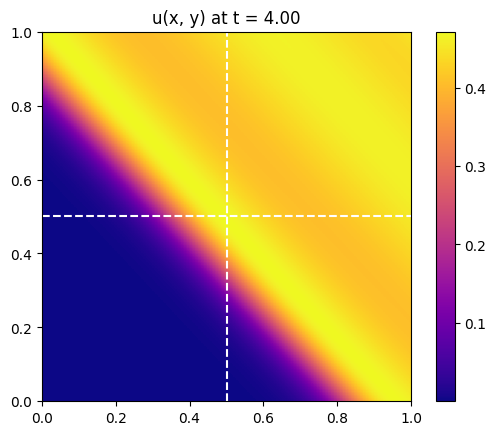

RHS max: 5.1936e-01, min: -1.3288e-01, mean: 4.0589e-02
iter: 9 ###############################
    Epoch [150/1500], Loss: 0.00152995
    Epoch [300/1500], Loss: 0.00158694
    Epoch [450/1500], Loss: 0.00150247
    Epoch [600/1500], Loss: 0.00155471
    Epoch [750/1500], Loss: 0.00149034
    Epoch [900/1500], Loss: 0.00155480
    Epoch [1050/1500], Loss: 0.00142839
    Epoch [1200/1500], Loss: 0.00140401
    Epoch [1350/1500], Loss: 0.00138546
    Epoch [1500/1500], Loss: 0.00141239
    Energy after iteration 9: 0.166929


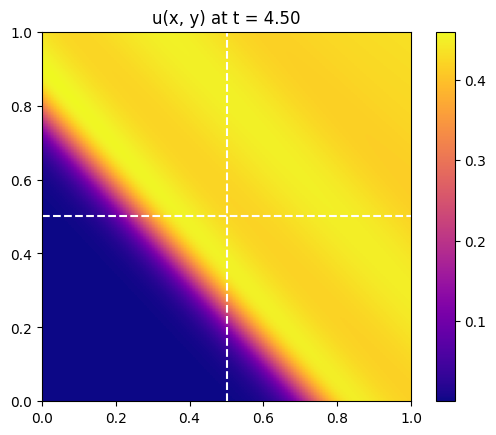

RHS max: 5.1936e-01, min: -9.9508e-02, mean: 3.4237e-02
iter: 10 ###############################
    Epoch [150/1500], Loss: 0.00307588
    Epoch [300/1500], Loss: 0.00309290
    Epoch [450/1500], Loss: 0.00307558
    Epoch [600/1500], Loss: 0.00306270
    Epoch [750/1500], Loss: 0.00305900
    Epoch [900/1500], Loss: 0.00464159
    Epoch [1050/1500], Loss: 0.00364594
    Epoch [1200/1500], Loss: 0.00306265
    Epoch [1350/1500], Loss: 0.00305829
    Epoch [1500/1500], Loss: 0.00305703
    Energy after iteration 10: 0.168639


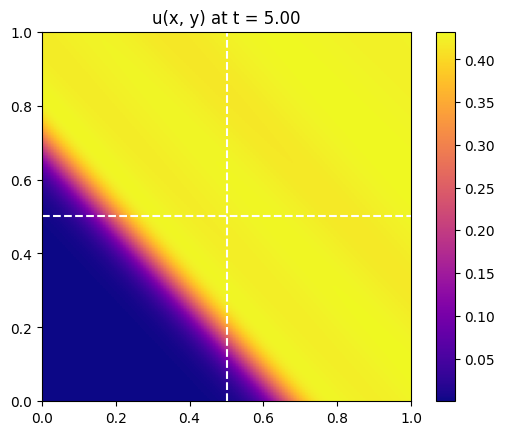

RHS max: 5.1936e-01, min: -1.7250e-02, mean: 4.8684e-02


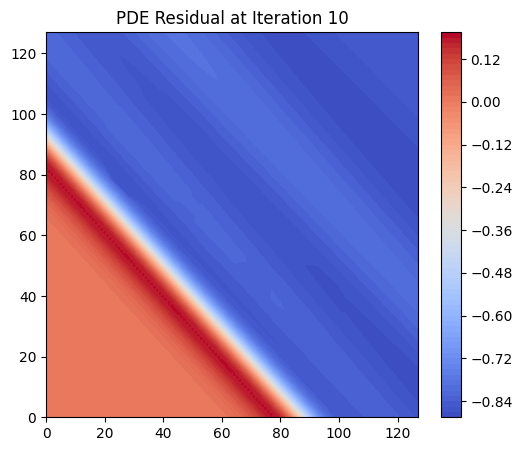

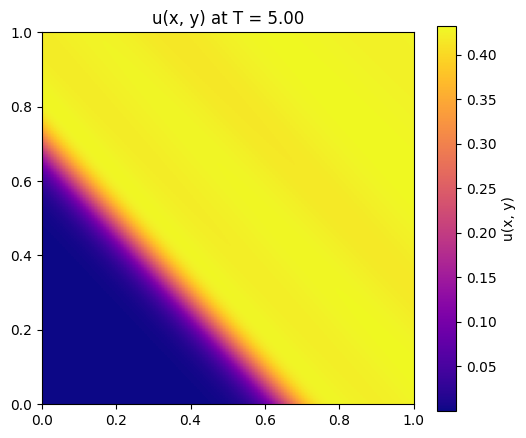

iter: 11 ###############################
    Epoch [150/1500], Loss: -0.00527661
    Epoch [300/1500], Loss: -0.00527164
    Epoch [450/1500], Loss: -0.00527999
    Epoch [600/1500], Loss: -0.00470984
    Epoch [750/1500], Loss: -0.00481648
    Epoch [900/1500], Loss: -0.00528171
    Epoch [1050/1500], Loss: -0.00528246
    Epoch [1200/1500], Loss: -0.00528292
    Epoch [1350/1500], Loss: -0.00528337
    Epoch [1500/1500], Loss: -0.00528384
    Energy after iteration 11: 0.166886


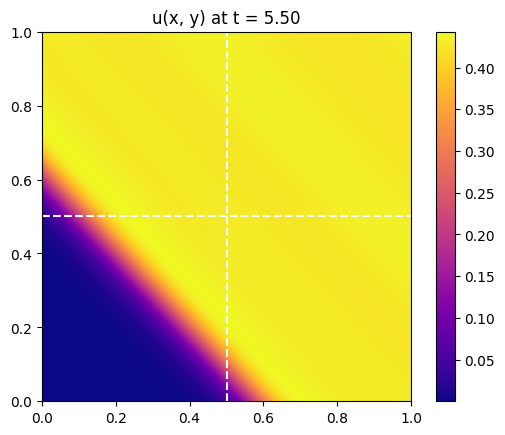

RHS max: 5.1936e-01, min: -4.9510e-02, mean: 3.1797e-02
iter: 12 ###############################
    Epoch [150/1500], Loss: -0.00197975
    Epoch [300/1500], Loss: -0.00176296
    Epoch [450/1500], Loss: -0.00197137
    Epoch [600/1500], Loss: -0.00185629
    Epoch [750/1500], Loss: -0.00197906
    Epoch [900/1500], Loss: -0.00197770
    Epoch [1050/1500], Loss: -0.00198411
    Epoch [1200/1500], Loss: -0.00199463
    Epoch [1350/1500], Loss: -0.00196530
    Epoch [1500/1500], Loss: -0.00188347
    Energy after iteration 12: 0.158955


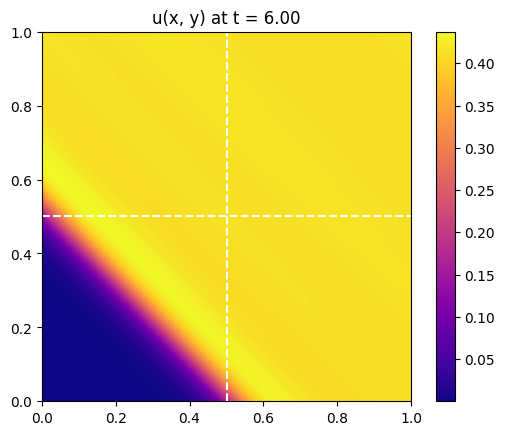

RHS max: 5.1936e-01, min: -3.2430e-02, mean: 6.1468e-02
iter: 13 ###############################
    Epoch [150/1500], Loss: -0.01782052
    Epoch [300/1500], Loss: -0.01664232
    Epoch [450/1500], Loss: -0.01782299
    Epoch [600/1500], Loss: -0.01782389
    Epoch [750/1500], Loss: -0.01782307
    Epoch [900/1500], Loss: -0.01782458
    Epoch [1050/1500], Loss: -0.01776028
    Epoch [1200/1500], Loss: -0.01766473
    Epoch [1350/1500], Loss: -0.01756207
    Epoch [1500/1500], Loss: -0.01782547
    Energy after iteration 13: 0.162268


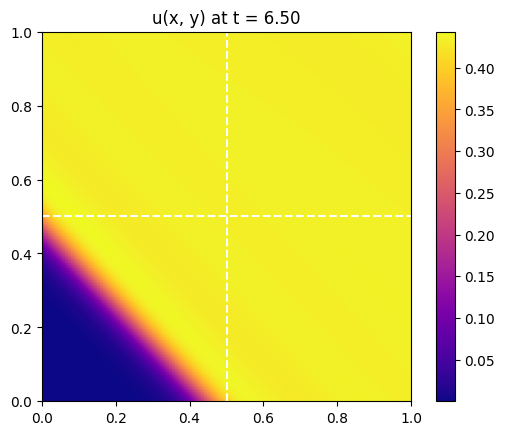

RHS max: 5.1936e-01, min: -5.0126e-02, mean: 8.4891e-03
iter: 14 ###############################
    Epoch [150/1500], Loss: 0.00576475
    Epoch [300/1500], Loss: 0.00576428
    Epoch [450/1500], Loss: 0.00576354
    Epoch [600/1500], Loss: 0.00584259
    Epoch [750/1500], Loss: 0.00579687
    Epoch [900/1500], Loss: 0.00576800
    Epoch [1050/1500], Loss: 0.00576825
    Epoch [1200/1500], Loss: 0.00596812
    Epoch [1350/1500], Loss: 0.00576981
    Epoch [1500/1500], Loss: 0.00576200
    Energy after iteration 14: 0.181900


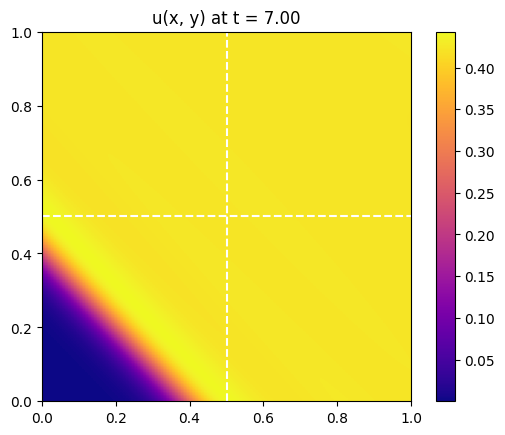

RHS max: 5.1936e-01, min: -4.9492e-02, mean: 2.9035e-02
iter: 15 ###############################
    Epoch [150/1500], Loss: -0.00510604
    Epoch [300/1500], Loss: -0.00505458
    Epoch [450/1500], Loss: -0.00508295
    Epoch [600/1500], Loss: -0.00508889
    Epoch [750/1500], Loss: -0.00511188
    Epoch [900/1500], Loss: -0.00509590
    Epoch [1050/1500], Loss: -0.00510481
    Epoch [1200/1500], Loss: -0.00511463
    Epoch [1350/1500], Loss: -0.00473677
    Epoch [1500/1500], Loss: -0.00510722
    Energy after iteration 15: 0.177456


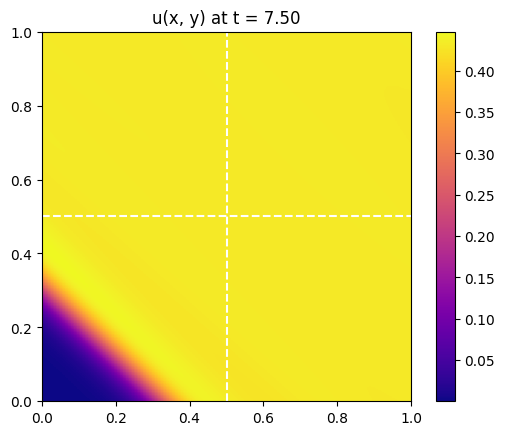

RHS max: 5.1936e-01, min: -6.2274e-02, mean: 3.8104e-03
iter: 16 ###############################
    Epoch [150/1500], Loss: 0.00465619
    Epoch [300/1500], Loss: 0.00466540
    Epoch [450/1500], Loss: 0.00495282
    Epoch [600/1500], Loss: 0.00475386
    Epoch [750/1500], Loss: 0.00478040
    Epoch [900/1500], Loss: 0.00465319
    Epoch [1050/1500], Loss: 0.00465408
    Epoch [1200/1500], Loss: 0.00466936
    Epoch [1350/1500], Loss: 0.00466175
    Epoch [1500/1500], Loss: 0.00467079
    Energy after iteration 16: 0.182921


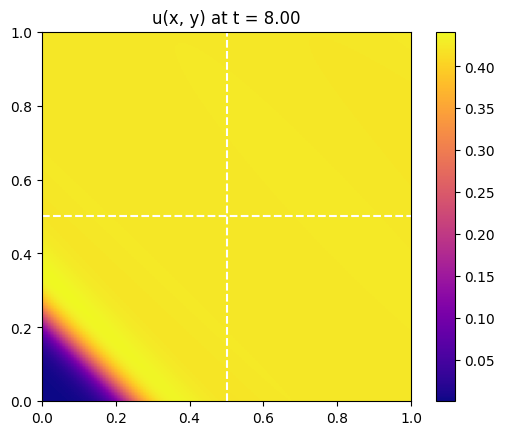

RHS max: 5.1936e-01, min: -4.4740e-02, mean: 1.9361e-02
iter: 17 ###############################
    Epoch [150/1500], Loss: -0.00462746
    Epoch [300/1500], Loss: -0.00461410
    Epoch [450/1500], Loss: -0.00462794
    Epoch [600/1500], Loss: -0.00458499
    Epoch [750/1500], Loss: -0.00456328
    Epoch [900/1500], Loss: -0.00462724
    Epoch [1050/1500], Loss: -0.00462655
    Epoch [1200/1500], Loss: -0.00462567
    Epoch [1350/1500], Loss: -0.00458129
    Epoch [1500/1500], Loss: -0.00462276
    Energy after iteration 17: 0.181558


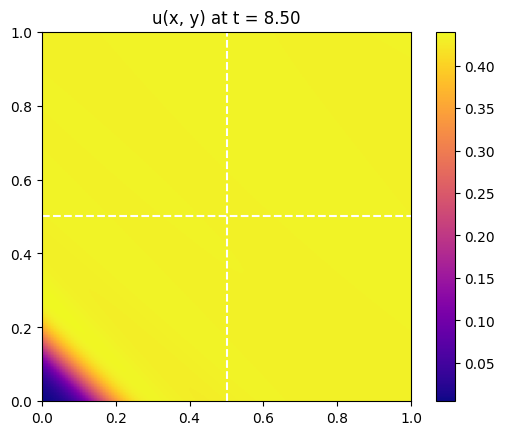

RHS max: 5.1936e-01, min: -3.9692e-02, mean: -9.8602e-03
iter: 18 ###############################
    Epoch [150/1500], Loss: 0.00636788
    Epoch [300/1500], Loss: 0.00636778
    Epoch [450/1500], Loss: 0.00688999
    Epoch [600/1500], Loss: 0.00636836
    Epoch [750/1500], Loss: 0.00636771
    Epoch [900/1500], Loss: 0.00636764
    Epoch [1050/1500], Loss: 0.00636756
    Epoch [1200/1500], Loss: 0.00636748
    Epoch [1350/1500], Loss: 0.00638177
    Epoch [1500/1500], Loss: 0.00647400
    Energy after iteration 18: 0.175161


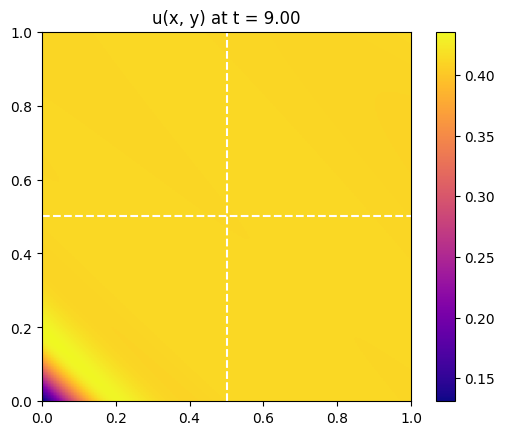

RHS max: 5.1936e-01, min: -2.6900e-02, mean: 4.6556e-02
iter: 19 ###############################
    Epoch [150/1500], Loss: -0.01926587
    Epoch [300/1500], Loss: -0.01913588
    Epoch [450/1500], Loss: -0.01917460
    Epoch [600/1500], Loss: -0.01926799
    Epoch [750/1500], Loss: -0.01926848
    Epoch [900/1500], Loss: -0.01925377
    Epoch [1050/1500], Loss: -0.01926982
    Epoch [1200/1500], Loss: -0.01926189
    Epoch [1350/1500], Loss: -0.01924945
    Epoch [1500/1500], Loss: -0.01926405
    Energy after iteration 19: 0.166569


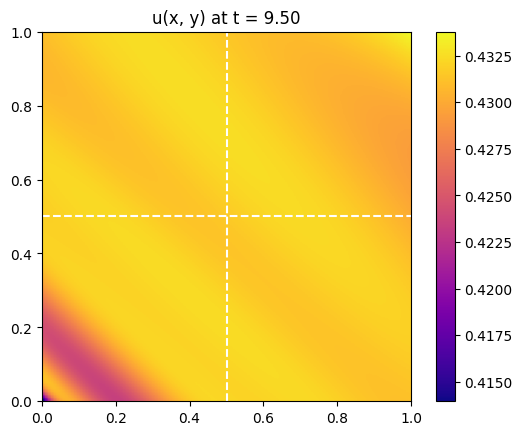

RHS max: 3.8928e-02, min: -2.1405e-02, mean: -1.4118e-02
iter: 20 ###############################
    Epoch [150/1500], Loss: 0.00638466
    Epoch [300/1500], Loss: 0.00665131
    Epoch [450/1500], Loss: 0.00638450
    Epoch [600/1500], Loss: 0.00638447
    Epoch [750/1500], Loss: 0.00638443
    Epoch [900/1500], Loss: 0.00658083
    Epoch [1050/1500], Loss: 0.00638450
    Epoch [1200/1500], Loss: 0.00638446
    Epoch [1350/1500], Loss: 0.00638442
    Epoch [1500/1500], Loss: 0.00638439
    Energy after iteration 20: 0.186259


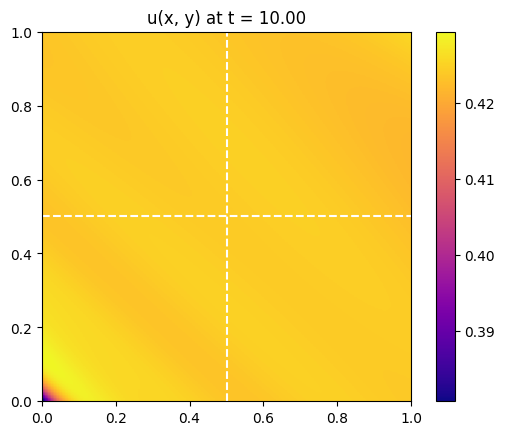

RHS max: 1.3952e-01, min: -7.9268e-03, mean: 7.8701e-03


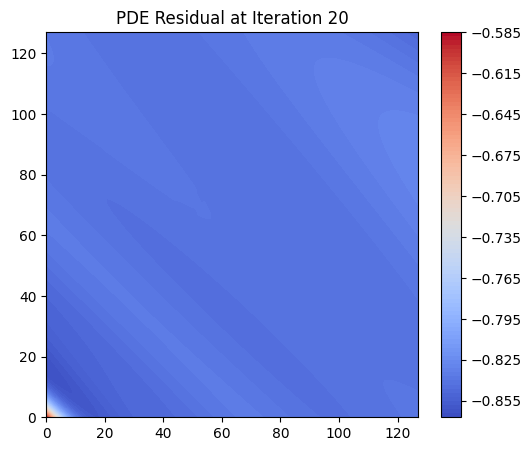

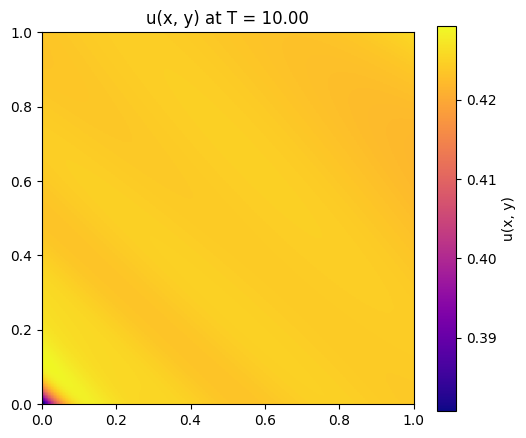

iter: 21 ###############################
    Epoch [150/1500], Loss: -0.00326119
    Epoch [300/1500], Loss: -0.00326123
    Epoch [450/1500], Loss: -0.00323860
    Epoch [600/1500], Loss: -0.00324335
    Epoch [750/1500], Loss: -0.00326125
    Epoch [900/1500], Loss: -0.00325710
    Epoch [1050/1500], Loss: -0.00326044
    Epoch [1200/1500], Loss: -0.00322678
    Epoch [1350/1500], Loss: -0.00326133
    Epoch [1500/1500], Loss: -0.00320918
    Energy after iteration 21: 0.182287


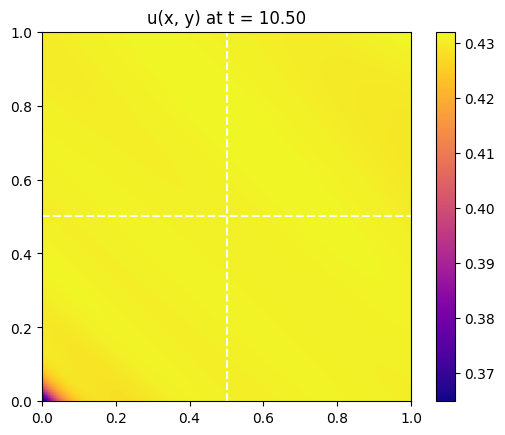

RHS max: 1.8695e-01, min: -1.6379e-02, mean: -1.1974e-02
iter: 22 ###############################
    Epoch [150/1500], Loss: 0.00527115
    Epoch [300/1500], Loss: 0.00531051
    Epoch [450/1500], Loss: 0.00527112
    Epoch [600/1500], Loss: 0.00527125
    Epoch [750/1500], Loss: 0.00527119
    Epoch [900/1500], Loss: 0.00527114
    Epoch [1050/1500], Loss: 0.00527111
    Epoch [1200/1500], Loss: 0.00527109
    Epoch [1350/1500], Loss: 0.00527108
    Epoch [1500/1500], Loss: 0.00527106
    Energy after iteration 22: 0.185538


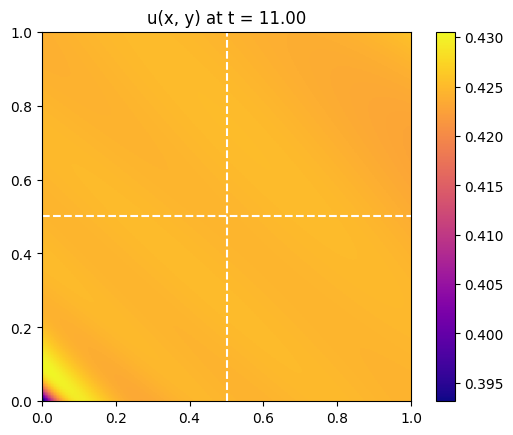

RHS max: 1.0234e-01, min: -1.1673e-02, mean: 6.4238e-03
iter: 23 ###############################
    Epoch [150/1500], Loss: -0.00276972
    Epoch [300/1500], Loss: -0.00276997
    Epoch [450/1500], Loss: -0.00148769
    Epoch [600/1500], Loss: -0.00276999
    Epoch [750/1500], Loss: -0.00277008
    Epoch [900/1500], Loss: -0.00277014
    Epoch [1050/1500], Loss: -0.00277019
    Epoch [1200/1500], Loss: -0.00277024
    Epoch [1350/1500], Loss: -0.00242844
    Epoch [1500/1500], Loss: -0.00277017
    Energy after iteration 23: 0.182051


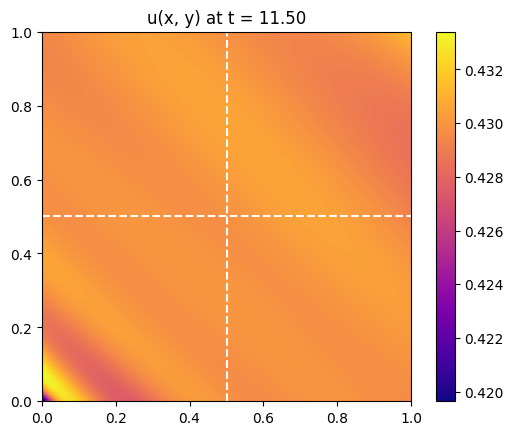

RHS max: 2.1586e-02, min: -2.0266e-02, mean: -9.5459e-03
iter: 24 ###############################
    Epoch [150/1500], Loss: 0.00417072
    Epoch [300/1500], Loss: 0.00417069
    Epoch [450/1500], Loss: 0.00417279
    Epoch [600/1500], Loss: 0.00417094
    Epoch [750/1500], Loss: 0.00429255
    Epoch [900/1500], Loss: 0.00419118
    Epoch [1050/1500], Loss: 0.00417185
    Epoch [1200/1500], Loss: 0.00417067
    Epoch [1350/1500], Loss: 0.00417063
    Epoch [1500/1500], Loss: 0.00417479
    Energy after iteration 24: 0.182733


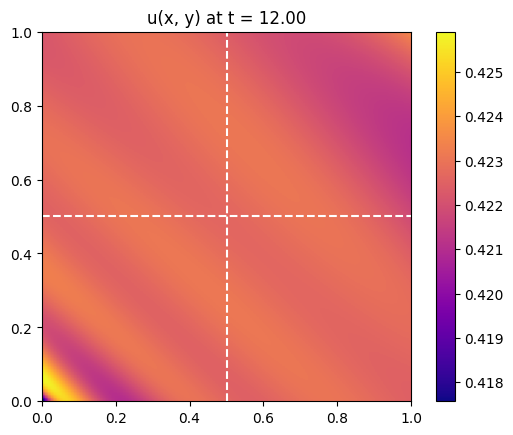

RHS max: 2.7900e-02, min: 2.4979e-03, mean: 1.2474e-02
iter: 25 ###############################
    Epoch [150/1500], Loss: -0.00527953
    Epoch [300/1500], Loss: -0.00527512
    Epoch [450/1500], Loss: -0.00486690
    Epoch [600/1500], Loss: -0.00526196
    Epoch [750/1500], Loss: -0.00527934
    Epoch [900/1500], Loss: -0.00527955
    Epoch [1050/1500], Loss: -0.00527952
    Epoch [1200/1500], Loss: -0.00515345
    Epoch [1350/1500], Loss: -0.00524904
    Epoch [1500/1500], Loss: -0.00526350
    Energy after iteration 25: 0.176097


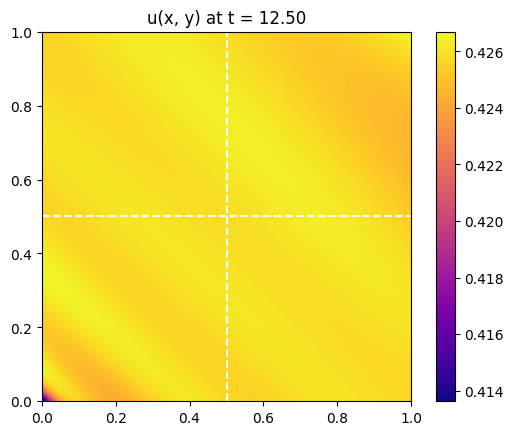

RHS max: 3.9940e-02, min: 9.6977e-05, mean: 2.6652e-03
iter: 26 ###############################
    Epoch [150/1500], Loss: -0.00111347
    Epoch [300/1500], Loss: -0.00111347
    Epoch [450/1500], Loss: -0.00111348
    Epoch [600/1500], Loss: -0.00111341
    Epoch [750/1500], Loss: -0.00111224
    Epoch [900/1500], Loss: -0.00110788
    Epoch [1050/1500], Loss: -0.00106634
    Epoch [1200/1500], Loss: -0.00111217
    Epoch [1350/1500], Loss: -0.00109684
    Epoch [1500/1500], Loss: -0.00111268
    Energy after iteration 26: 0.181225


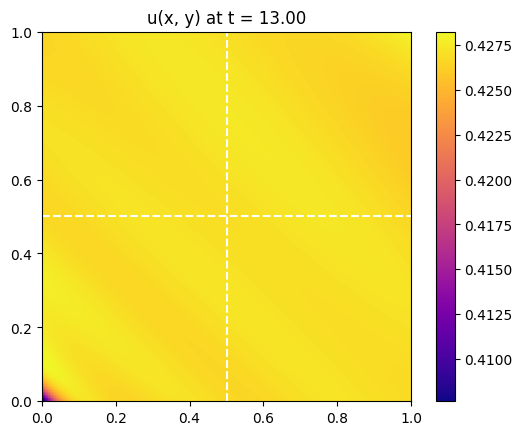

RHS max: 5.8161e-02, min: -4.5704e-03, mean: -7.9957e-04
iter: 27 ###############################
    Epoch [150/1500], Loss: 0.00037748
    Epoch [300/1500], Loss: 0.00037746
    Epoch [450/1500], Loss: 0.00037745
    Epoch [600/1500], Loss: 0.00228669
    Epoch [750/1500], Loss: 0.00037761
    Epoch [900/1500], Loss: 0.00037755
    Epoch [1050/1500], Loss: 0.00037752
    Epoch [1200/1500], Loss: 0.00037751
    Epoch [1350/1500], Loss: 0.00037750
    Epoch [1500/1500], Loss: 0.00037749
    Energy after iteration 27: 0.182345


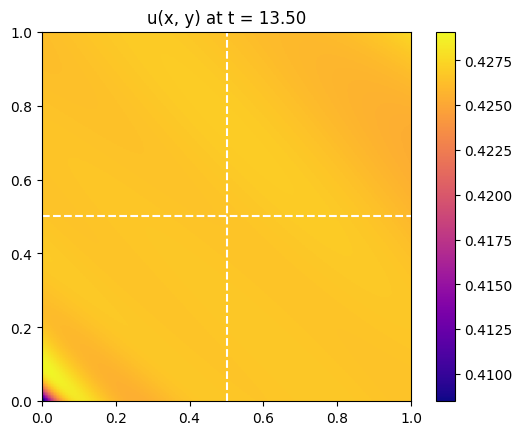

RHS max: 5.5655e-02, min: -7.2295e-03, mean: 5.8608e-04
iter: 28 ###############################
    Epoch [150/1500], Loss: -0.00020305
    Epoch [300/1500], Loss: -0.00020306
    Epoch [450/1500], Loss: -0.00020306
    Epoch [600/1500], Loss: -0.00019129
    Epoch [750/1500], Loss: -0.00011756
    Epoch [900/1500], Loss: -0.00019035
    Epoch [1050/1500], Loss: -0.00019794
    Epoch [1200/1500], Loss: -0.00017638
    Epoch [1350/1500], Loss: -0.00020145
    Epoch [1500/1500], Loss: -0.00020303
    Energy after iteration 28: 0.182206


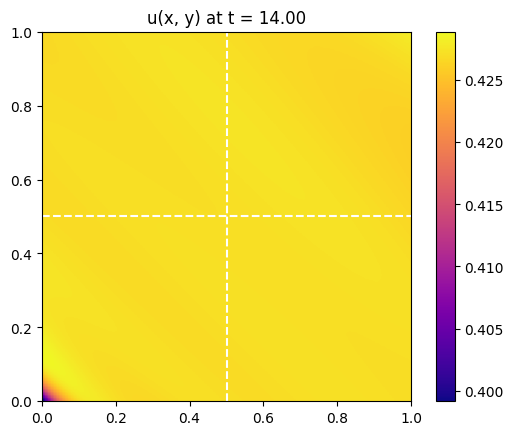

RHS max: 8.4063e-02, min: -6.5987e-03, mean: -9.3987e-04
iter: 29 ###############################
    Epoch [150/1500], Loss: 0.00046781
    Epoch [300/1500], Loss: 0.00046778
    Epoch [450/1500], Loss: 0.00046777
    Epoch [600/1500], Loss: 0.00272412
    Epoch [750/1500], Loss: 0.00046784
    Epoch [900/1500], Loss: 0.00046781
    Epoch [1050/1500], Loss: 0.00046780
    Epoch [1200/1500], Loss: 0.00046778
    Epoch [1350/1500], Loss: 0.00046777
    Epoch [1500/1500], Loss: 0.00046777
    Energy after iteration 29: 0.182405


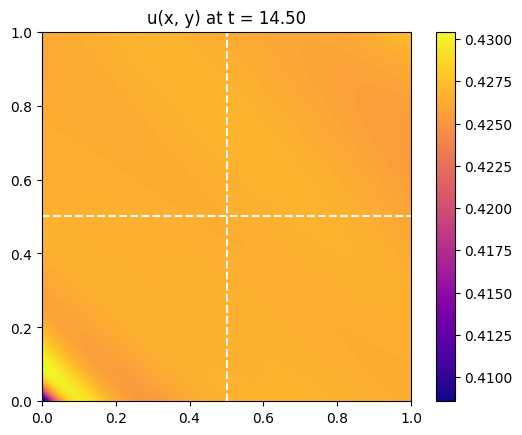

RHS max: 5.5368e-02, min: -1.1264e-02, mean: 6.2588e-04
iter: 30 ###############################
    Epoch [150/1500], Loss: -0.00021457
    Epoch [300/1500], Loss: -0.00021458
    Epoch [450/1500], Loss: -0.00021459
    Epoch [600/1500], Loss: -0.00021460
    Epoch [750/1500], Loss: -0.00021384
    Epoch [900/1500], Loss: -0.00021460
    Epoch [1050/1500], Loss: -0.00021461
    Epoch [1200/1500], Loss: -0.00021265
    Epoch [1350/1500], Loss: -0.00021452
    Epoch [1500/1500], Loss: -0.00021453
    Energy after iteration 30: 0.181955


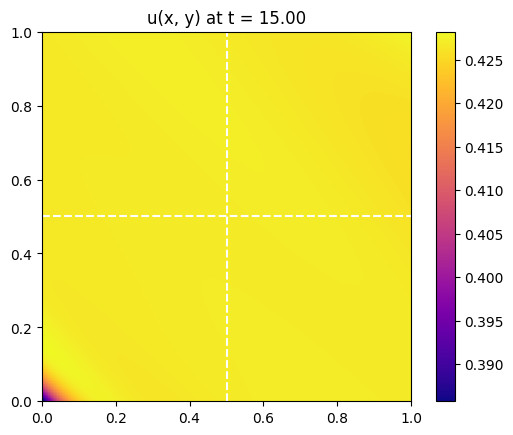

RHS max: 1.2471e-01, min: -4.5180e-03, mean: 1.6573e-04


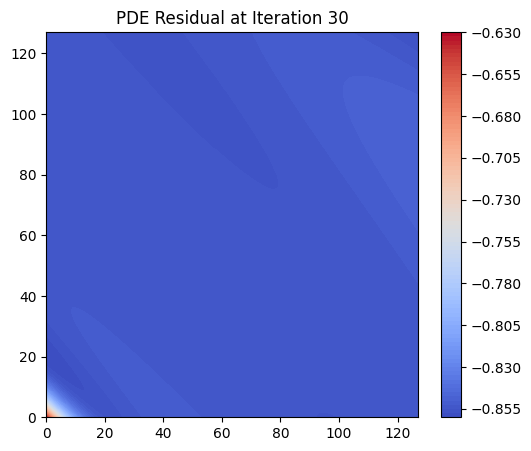

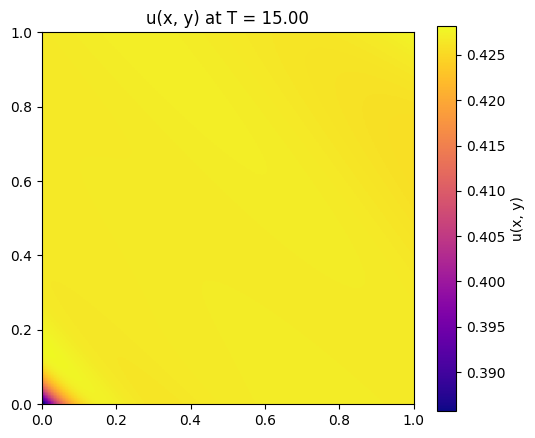

iter: 31 ###############################
    Epoch [150/1500], Loss: 0.00005795
    Epoch [300/1500], Loss: 0.00005784
    Epoch [450/1500], Loss: 0.00005775
    Epoch [600/1500], Loss: 0.00005768
    Epoch [750/1500], Loss: 0.00005782
    Epoch [900/1500], Loss: 0.00005763
    Epoch [1050/1500], Loss: 0.00005760
    Epoch [1200/1500], Loss: 0.00009578
    Epoch [1350/1500], Loss: 0.00005757
    Epoch [1500/1500], Loss: 0.00006184
    Energy after iteration 31: 0.180326


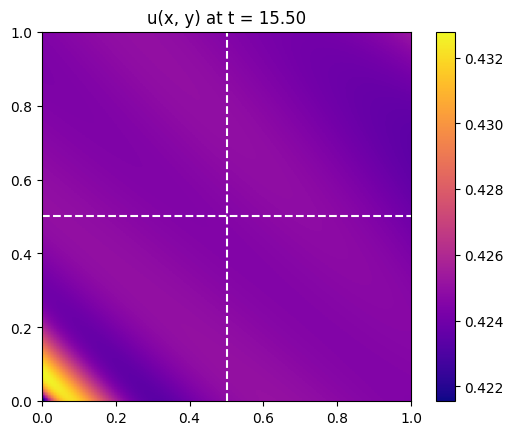

RHS max: 1.5774e-02, min: -1.8404e-02, mean: 6.2921e-03
iter: 32 ###############################
    Epoch [150/1500], Loss: -0.00277815
    Epoch [300/1500], Loss: -0.00277816
    Epoch [450/1500], Loss: -0.00277818
    Epoch [600/1500], Loss: -0.00277819
    Epoch [750/1500], Loss: -0.00267381
    Epoch [900/1500], Loss: -0.00277821
    Epoch [1050/1500], Loss: -0.00277753
    Epoch [1200/1500], Loss: -0.00277820
    Epoch [1350/1500], Loss: -0.00277821
    Epoch [1500/1500], Loss: -0.00277822
    Energy after iteration 32: 0.180262


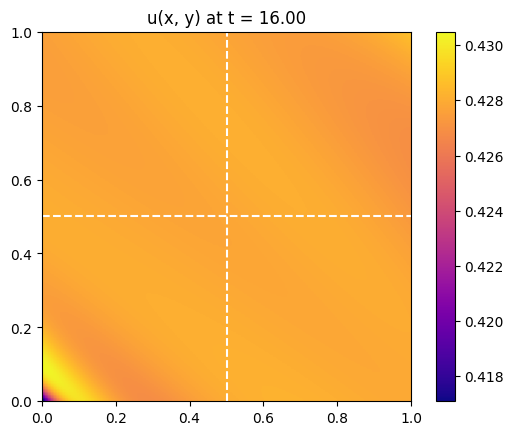

RHS max: 2.9347e-02, min: -1.1419e-02, mean: -3.3421e-03
iter: 33 ###############################
    Epoch [150/1500], Loss: 0.00145133
    Epoch [300/1500], Loss: 0.00145133
    Epoch [450/1500], Loss: 0.00145133
    Epoch [600/1500], Loss: 0.00145132
    Epoch [750/1500], Loss: 0.00145180
    Epoch [900/1500], Loss: 0.00145134
    Epoch [1050/1500], Loss: 0.00145134
    Epoch [1200/1500], Loss: 0.00145134
    Epoch [1350/1500], Loss: 0.00145133
    Epoch [1500/1500], Loss: 0.00145133
    Energy after iteration 33: 0.183049


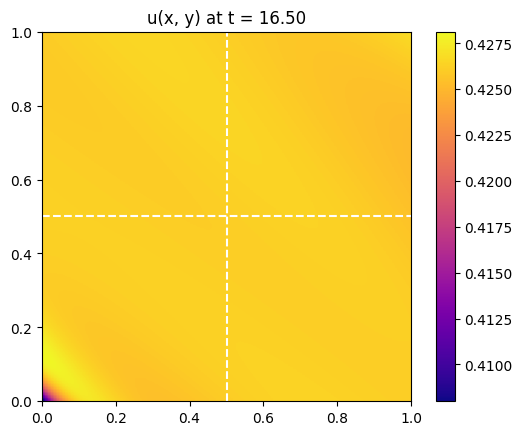

RHS max: 5.7134e-02, min: -4.3002e-03, mean: 1.8417e-03
iter: 34 ###############################
    Epoch [150/1500], Loss: -0.00076008
    Epoch [300/1500], Loss: -0.00076011
    Epoch [450/1500], Loss: -0.00076012
    Epoch [600/1500], Loss: -0.00076013
    Epoch [750/1500], Loss: 0.00350583
    Epoch [900/1500], Loss: -0.00076002
    Epoch [1050/1500], Loss: -0.00076005
    Epoch [1200/1500], Loss: -0.00076007
    Epoch [1350/1500], Loss: -0.00076008
    Epoch [1500/1500], Loss: -0.00076010
    Energy after iteration 34: 0.181596


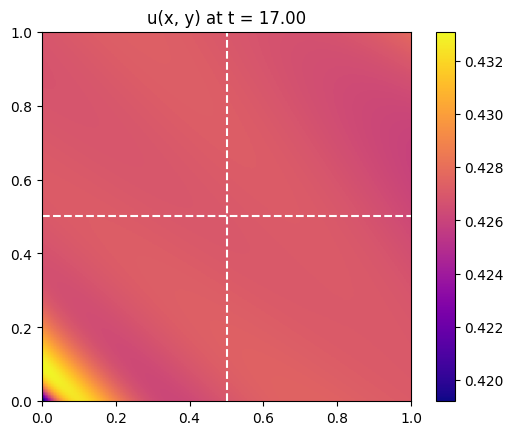

RHS max: 2.2891e-02, min: -1.9286e-02, mean: -9.7791e-04
iter: 35 ###############################
    Epoch [150/1500], Loss: 0.00040370
    Epoch [300/1500], Loss: 0.00040368
    Epoch [450/1500], Loss: 0.00040367
    Epoch [600/1500], Loss: 0.00040367
    Epoch [750/1500], Loss: 0.00040366
    Epoch [900/1500], Loss: 0.00040366
    Epoch [1050/1500], Loss: 0.00040376
    Epoch [1200/1500], Loss: 0.00040368
    Epoch [1350/1500], Loss: 0.00040367
    Epoch [1500/1500], Loss: 0.00040367
    Energy after iteration 35: 0.182362


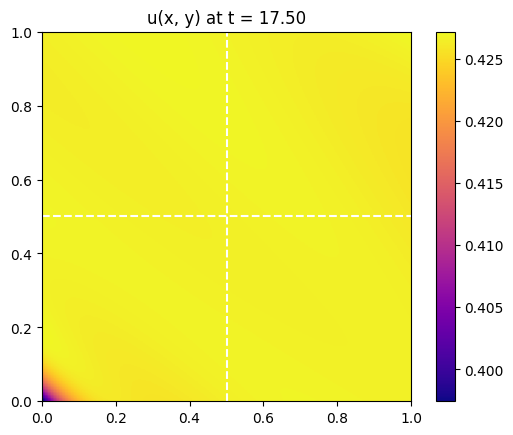

RHS max: 8.9279e-02, min: -1.3804e-03, mean: 6.7551e-04
iter: 36 ###############################
    Epoch [150/1500], Loss: -0.00019066
    Epoch [300/1500], Loss: -0.00019067
    Epoch [450/1500], Loss: -0.00019067
    Epoch [600/1500], Loss: -0.00019067
    Epoch [750/1500], Loss: -0.00019067
    Epoch [900/1500], Loss: -0.00019067
    Epoch [1050/1500], Loss: 0.00217921
    Epoch [1200/1500], Loss: -0.00019054
    Epoch [1350/1500], Loss: -0.00019067
    Epoch [1500/1500], Loss: -0.00019067
    Energy after iteration 36: 0.181971


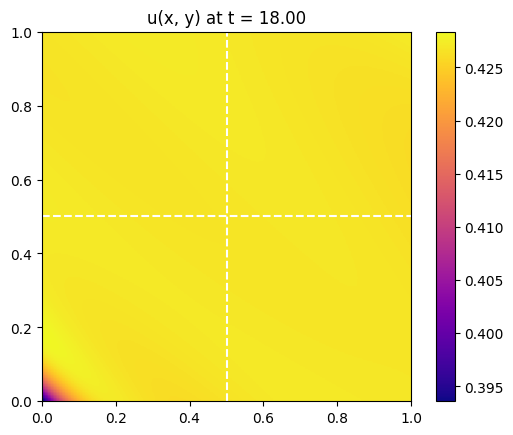

RHS max: 1.0089e-01, min: -4.9578e-03, mean: -8.5738e-05
iter: 37 ###############################
    Epoch [150/1500], Loss: 0.00008252
    Epoch [300/1500], Loss: 0.00008252
    Epoch [450/1500], Loss: 0.00008252
    Epoch [600/1500], Loss: 0.00008252
    Epoch [750/1500], Loss: 0.00008251
    Epoch [900/1500], Loss: 0.00008251
    Epoch [1050/1500], Loss: 0.00008251
    Epoch [1200/1500], Loss: 0.00016738
    Epoch [1350/1500], Loss: 0.00008252
    Epoch [1500/1500], Loss: 0.00008252
    Energy after iteration 37: 0.182151


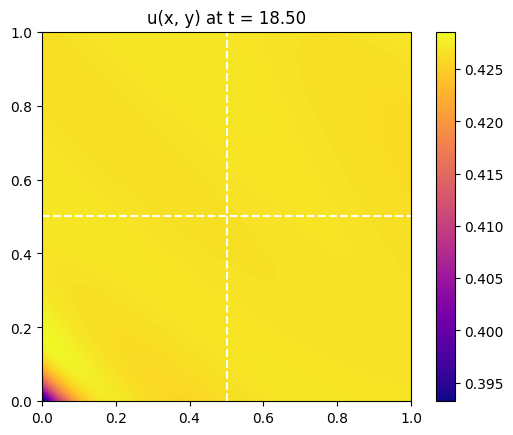

RHS max: 1.0208e-01, min: -5.6869e-03, mean: 1.5011e-04
iter: 38 ###############################
    Epoch [150/1500], Loss: -0.00004386
    Epoch [300/1500], Loss: -0.00004388
    Epoch [450/1500], Loss: -0.00004389
    Epoch [600/1500], Loss: -0.00004390
    Epoch [750/1500], Loss: -0.00004390
    Epoch [900/1500], Loss: -0.00004391
    Epoch [1050/1500], Loss: -0.00004391
    Epoch [1200/1500], Loss: -0.00004392
    Epoch [1350/1500], Loss: -0.00004256
    Epoch [1500/1500], Loss: -0.00004252
    Energy after iteration 38: 0.181205


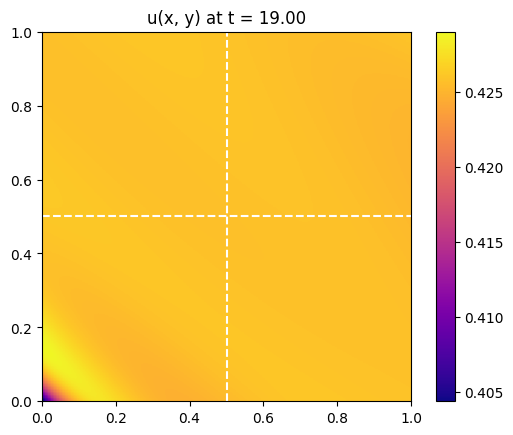

RHS max: 6.8106e-02, min: -6.8796e-03, mean: 2.8977e-03
iter: 39 ###############################
    Epoch [150/1500], Loss: -0.00129384
    Epoch [300/1500], Loss: -0.00129389
    Epoch [450/1500], Loss: -0.00129393
    Epoch [600/1500], Loss: -0.00129396
    Epoch [750/1500], Loss: -0.00129399
    Epoch [900/1500], Loss: -0.00129402
    Epoch [1050/1500], Loss: -0.00129404
    Epoch [1200/1500], Loss: -0.00129403
    Epoch [1350/1500], Loss: -0.00129405
    Epoch [1500/1500], Loss: -0.00129407
    Energy after iteration 39: 0.181244


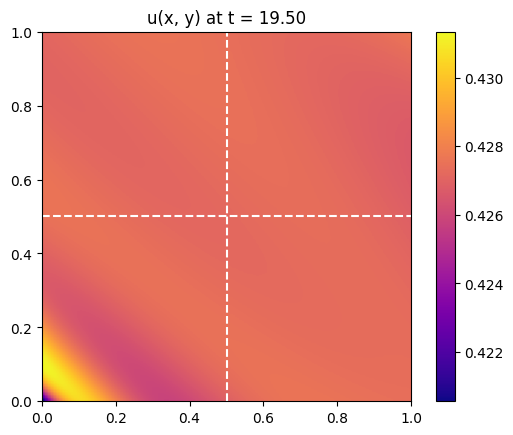

RHS max: 1.8776e-02, min: -1.4020e-02, mean: -1.6399e-03
iter: 40 ###############################
    Epoch [150/1500], Loss: 0.00067048
    Epoch [300/1500], Loss: 0.00067047
    Epoch [450/1500], Loss: 0.00067047
    Epoch [600/1500], Loss: 0.00067047
    Epoch [750/1500], Loss: 0.00067046
    Epoch [900/1500], Loss: 0.00067046
    Epoch [1050/1500], Loss: 0.00067046
    Epoch [1200/1500], Loss: 0.00067046
    Epoch [1350/1500], Loss: 0.00083902
    Epoch [1500/1500], Loss: 0.00067048
    Energy after iteration 40: 0.182542


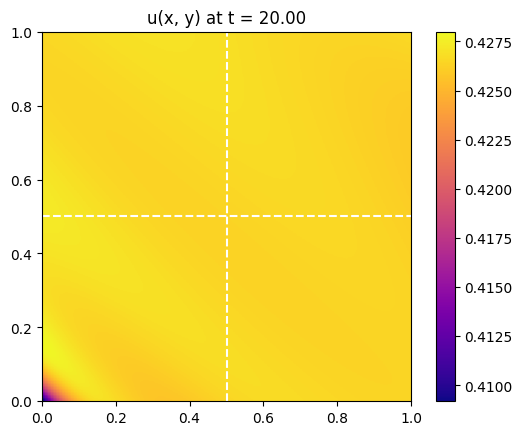

RHS max: 5.3448e-02, min: -3.8552e-03, mean: 5.5451e-04


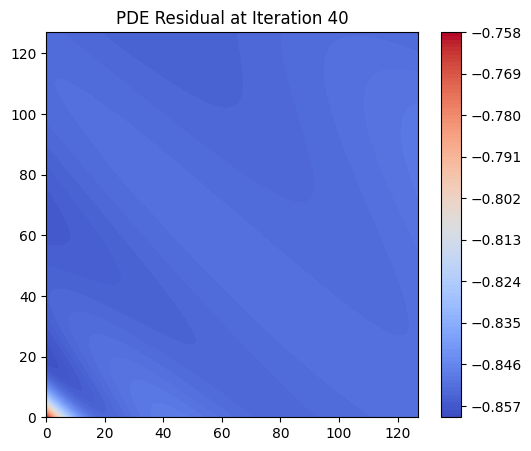

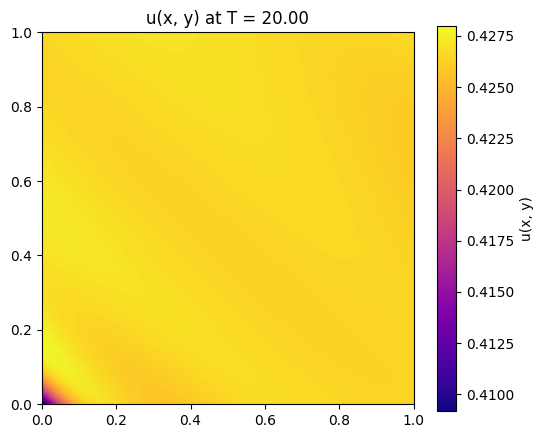

iter: 41 ###############################
    Epoch [150/1500], Loss: -0.00032059
    Epoch [300/1500], Loss: -0.00032060
    Epoch [450/1500], Loss: -0.00032060
    Epoch [600/1500], Loss: -0.00032060
    Epoch [750/1500], Loss: -0.00032060
    Epoch [900/1500], Loss: -0.00032060
    Epoch [1050/1500], Loss: -0.00032061
    Epoch [1200/1500], Loss: -0.00032061
    Epoch [1350/1500], Loss: -0.00032061
    Epoch [1500/1500], Loss: -0.00032061
    Energy after iteration 41: 0.181885


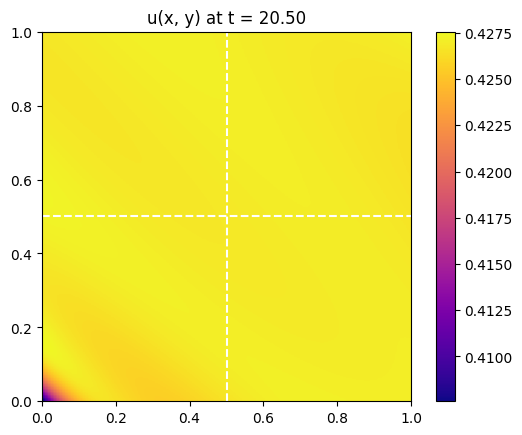

RHS max: 5.8387e-02, min: -2.5365e-03, mean: -3.0732e-04
iter: 42 ###############################
    Epoch [150/1500], Loss: 0.00015860
    Epoch [300/1500], Loss: 0.00015860
    Epoch [450/1500], Loss: 0.00015860
    Epoch [600/1500], Loss: 0.00015860
    Epoch [750/1500], Loss: 0.00015860
    Epoch [900/1500], Loss: 0.00015859
    Epoch [1050/1500], Loss: 0.00015859
    Epoch [1200/1500], Loss: 0.00015859
    Epoch [1350/1500], Loss: 0.00015859
    Epoch [1500/1500], Loss: 0.01324939
    Energy after iteration 42: 0.161551


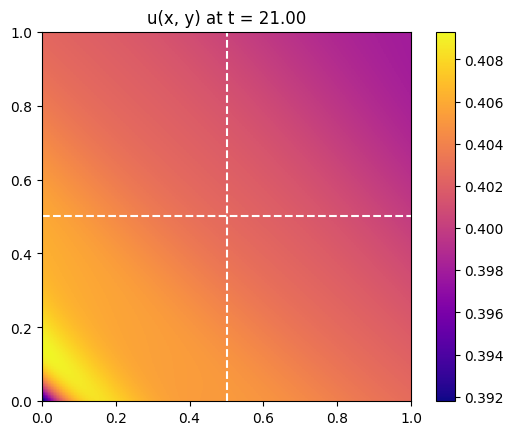

RHS max: 1.0641e-01, min: 5.3076e-02, mean: 7.3135e-02
iter: 43 ###############################
    Epoch [150/1500], Loss: -0.03203193
    Epoch [300/1500], Loss: -0.03203193
    Epoch [450/1500], Loss: -0.03203193
    Epoch [600/1500], Loss: -0.03203193
    Epoch [750/1500], Loss: -0.03203193
    Epoch [900/1500], Loss: -0.03203193
    Epoch [1050/1500], Loss: -0.03203193
    Epoch [1200/1500], Loss: -0.03203193
    Epoch [1350/1500], Loss: -0.03202706
    Epoch [1500/1500], Loss: -0.03203193
    Energy after iteration 43: 0.159962


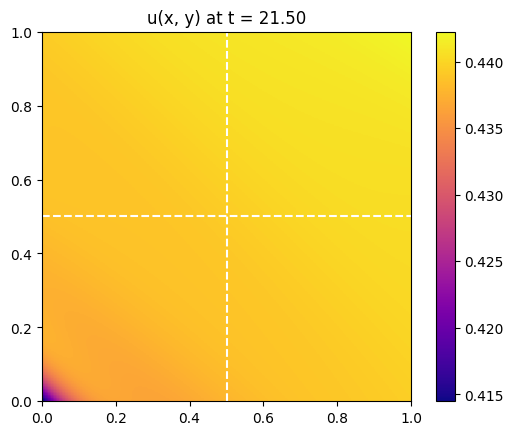

RHS max: 3.7304e-02, min: -4.6910e-02, mean: -3.8213e-02
iter: 44 ###############################
    Epoch [150/1500], Loss: 0.01703053
    Epoch [300/1500], Loss: 0.01703049
    Epoch [450/1500], Loss: 0.01703047
    Epoch [600/1500], Loss: 0.01703045
    Epoch [750/1500], Loss: 0.01703044
    Epoch [900/1500], Loss: 0.01703043
    Epoch [1050/1500], Loss: 0.01703042
    Epoch [1200/1500], Loss: 0.01703075
    Epoch [1350/1500], Loss: 0.01703041
    Epoch [1500/1500], Loss: 0.01703040
    Energy after iteration 44: 0.193042


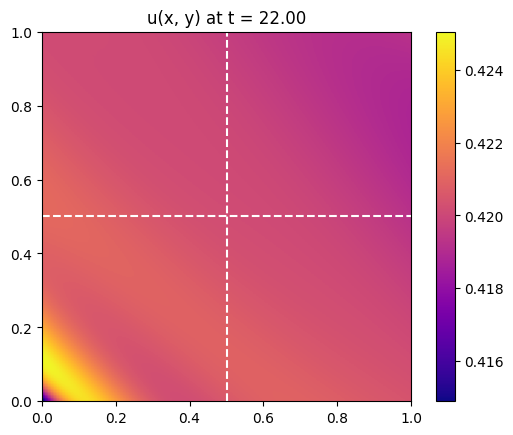

RHS max: 3.6079e-02, min: 5.0977e-03, mean: 1.9652e-02
iter: 45 ###############################
    Epoch [150/1500], Loss: -0.00867131
    Epoch [300/1500], Loss: -0.00867132
    Epoch [450/1500], Loss: -0.00867133
    Epoch [600/1500], Loss: -0.00867133
    Epoch [750/1500], Loss: -0.00867134
    Epoch [900/1500], Loss: -0.00867134
    Epoch [1050/1500], Loss: -0.00867134
    Epoch [1200/1500], Loss: -0.00867134
    Epoch [1350/1500], Loss: -0.00867133
    Epoch [1500/1500], Loss: -0.00867134
    Energy after iteration 45: 0.176320


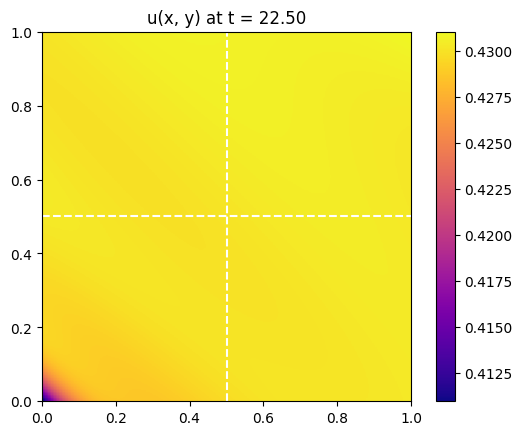

RHS max: 4.8031e-02, min: -1.3044e-02, mean: -1.0226e-02
iter: 46 ###############################
    Epoch [150/1500], Loss: 0.00454039
    Epoch [300/1500], Loss: 0.00454037
    Epoch [450/1500], Loss: 0.00454036
    Epoch [600/1500], Loss: 0.00454035
    Epoch [750/1500], Loss: 0.00454034
    Epoch [900/1500], Loss: 0.00454033
    Epoch [1050/1500], Loss: 0.00454033
    Epoch [1200/1500], Loss: 0.00454032
    Epoch [1350/1500], Loss: 0.00732844
    Epoch [1500/1500], Loss: 0.00454035
    Energy after iteration 46: 0.185042


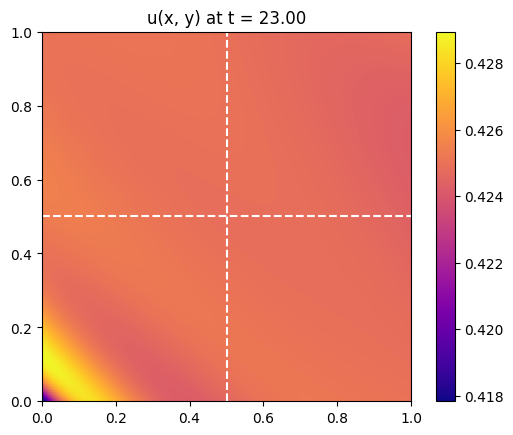

RHS max: 2.7091e-02, min: -6.7492e-03, mean: 5.3038e-03
iter: 47 ###############################
    Epoch [150/1500], Loss: -0.00238820
    Epoch [300/1500], Loss: -0.00238820
    Epoch [450/1500], Loss: -0.00238821
    Epoch [600/1500], Loss: -0.00238821
    Epoch [750/1500], Loss: -0.00238821
    Epoch [900/1500], Loss: -0.00238821
    Epoch [1050/1500], Loss: -0.00238822
    Epoch [1200/1500], Loss: -0.00238822
    Epoch [1350/1500], Loss: -0.00238822
    Epoch [1500/1500], Loss: -0.00238822
    Energy after iteration 47: 0.180520


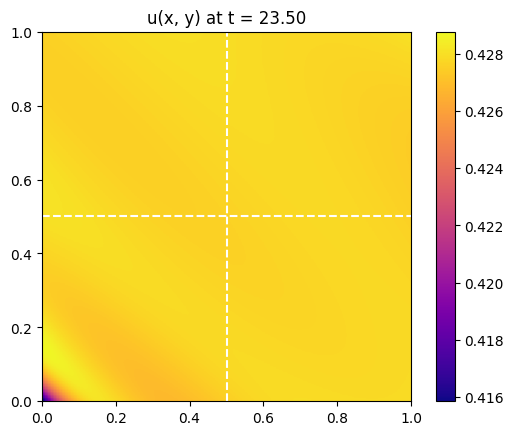

RHS max: 3.3110e-02, min: -6.1817e-03, mean: -2.9498e-03
iter: 48 ###############################
    Epoch [150/1500], Loss: 0.00125704
    Epoch [300/1500], Loss: 0.00125704
    Epoch [450/1500], Loss: 0.00125704
    Epoch [600/1500], Loss: 0.00125704
    Epoch [750/1500], Loss: 0.00125704
    Epoch [900/1500], Loss: 0.00125704
    Epoch [1050/1500], Loss: 0.00125704
    Epoch [1200/1500], Loss: 0.00125704
    Epoch [1350/1500], Loss: 0.00125703
    Epoch [1500/1500], Loss: 0.00125703
    Energy after iteration 48: 0.182922


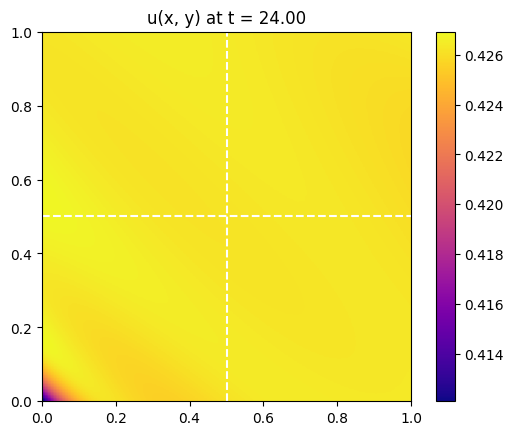

RHS max: 4.4625e-02, min: -5.9891e-04, mean: 1.4262e-03
iter: 49 ###############################
    Epoch [150/1500], Loss: -0.00065413
    Epoch [300/1500], Loss: -0.00065414
    Epoch [450/1500], Loss: -0.00065415
    Epoch [600/1500], Loss: -0.00065415
    Epoch [750/1500], Loss: -0.00065415
    Epoch [900/1500], Loss: -0.00065415
    Epoch [1050/1500], Loss: -0.00065415
    Epoch [1200/1500], Loss: -0.00065415
    Epoch [1350/1500], Loss: -0.00065415
    Epoch [1500/1500], Loss: -0.00065415
    Energy after iteration 49: 0.181666


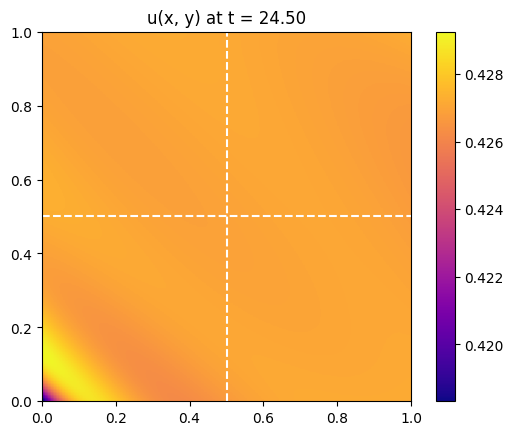

RHS max: 2.5610e-02, min: -7.6751e-03, mean: -8.8165e-04
iter: 50 ###############################
    Epoch [150/1500], Loss: 0.00034082
    Epoch [300/1500], Loss: 0.00034081
    Epoch [450/1500], Loss: 0.00034081
    Epoch [600/1500], Loss: 0.00034081
    Epoch [750/1500], Loss: 0.00034081
    Epoch [900/1500], Loss: 0.00034081
    Epoch [1050/1500], Loss: 0.00034081
    Epoch [1200/1500], Loss: 0.00034081
    Epoch [1350/1500], Loss: 0.00034080
    Epoch [1500/1500], Loss: 0.00034080
    Energy after iteration 50: 0.182321


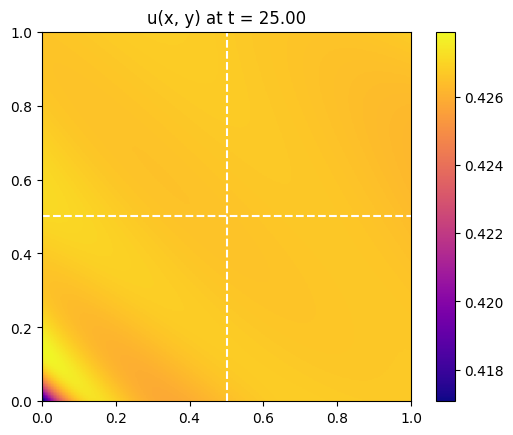

RHS max: 2.9419e-02, min: -3.6081e-03, mean: 3.1427e-04


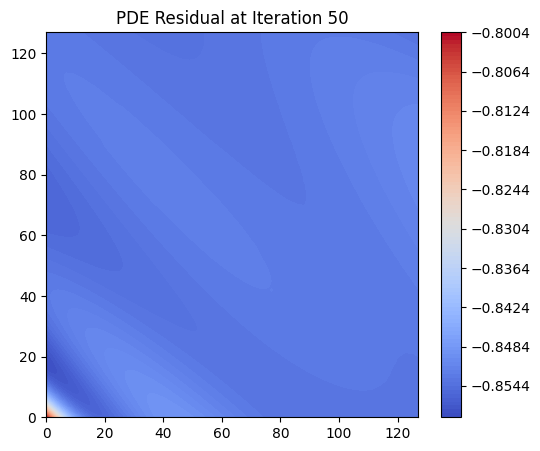

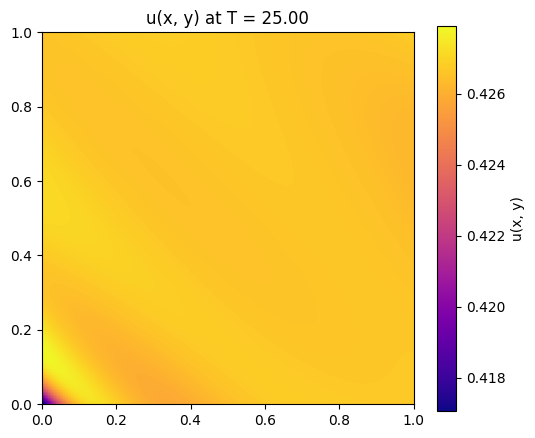

iter: 51 ###############################
    Epoch [150/1500], Loss: -0.00017498
    Epoch [300/1500], Loss: -0.00017498
    Epoch [450/1500], Loss: -0.00017498
    Epoch [600/1500], Loss: -0.00017498
    Epoch [750/1500], Loss: -0.00017499
    Epoch [900/1500], Loss: -0.00017499
    Epoch [1050/1500], Loss: -0.00017499
    Epoch [1200/1500], Loss: -0.00017499
    Epoch [1350/1500], Loss: -0.00017499
    Epoch [1500/1500], Loss: -0.00017499
    Energy after iteration 51: 0.181982


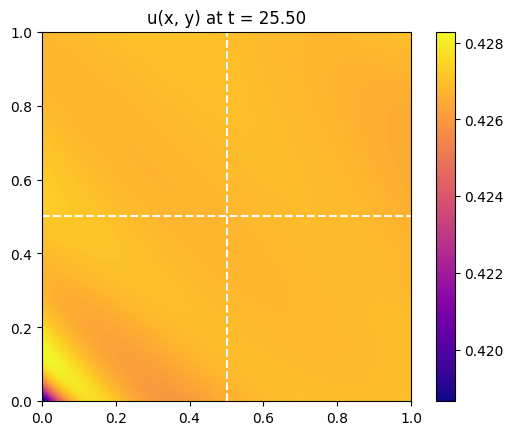

RHS max: 2.4583e-02, min: -4.7417e-03, mean: -2.8089e-04
iter: 52 ###############################
    Epoch [150/1500], Loss: 0.00007755
    Epoch [300/1500], Loss: 0.00007753
    Epoch [450/1500], Loss: 0.00007752
    Epoch [600/1500], Loss: 0.00007752
    Epoch [750/1500], Loss: 0.00007752
    Epoch [900/1500], Loss: 0.00007751
    Epoch [1050/1500], Loss: 0.00007751
    Epoch [1200/1500], Loss: 0.00007751
    Epoch [1350/1500], Loss: 0.00007751
    Epoch [1500/1500], Loss: 0.00007750
    Energy after iteration 52: 0.182148


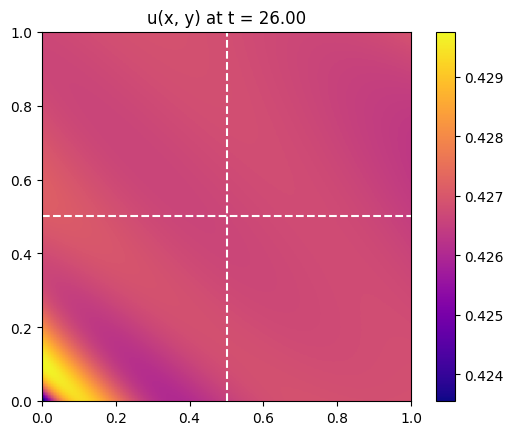

RHS max: 9.6700e-03, min: -9.2059e-03, mean: -9.5898e-05
iter: 53 ###############################
    Epoch [150/1500], Loss: -0.00003081
    Epoch [300/1500], Loss: -0.00003083
    Epoch [450/1500], Loss: -0.00003083
    Epoch [600/1500], Loss: -0.00003083
    Epoch [750/1500], Loss: -0.00003083
    Epoch [900/1500], Loss: -0.00003083
    Epoch [1050/1500], Loss: -0.00003083
    Epoch [1200/1500], Loss: -0.00003083
    Epoch [1350/1500], Loss: -0.00003083
    Epoch [1500/1500], Loss: -0.00003083
    Energy after iteration 53: 0.182076


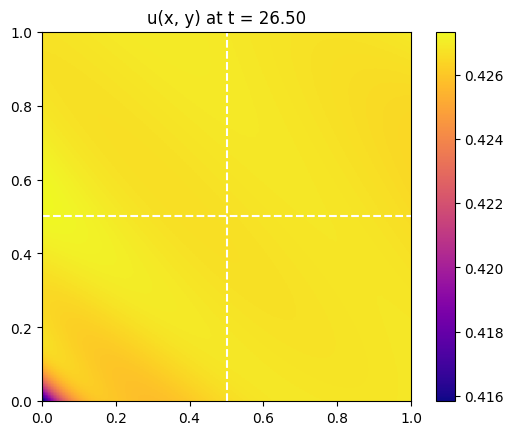

RHS max: 3.3212e-02, min: -1.8708e-03, mean: -9.2822e-06
iter: 54 ###############################
    Epoch [150/1500], Loss: -0.00000016
    Epoch [300/1500], Loss: -0.00000018
    Epoch [450/1500], Loss: -0.00000018
    Epoch [600/1500], Loss: -0.00000018
    Epoch [750/1500], Loss: -0.00000018
    Epoch [900/1500], Loss: -0.00000018
    Epoch [1050/1500], Loss: -0.00000018
    Epoch [1200/1500], Loss: -0.00000018
    Epoch [1350/1500], Loss: -0.00000018
    Epoch [1500/1500], Loss: 0.00000001
    Energy after iteration 54: 0.181744


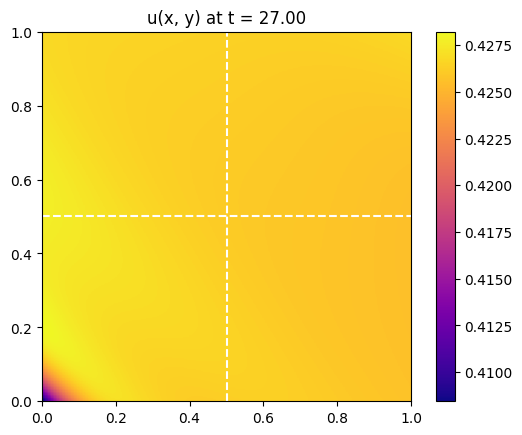

RHS max: 5.5740e-02, min: -4.5193e-03, mean: 1.2068e-03
iter: 55 ###############################
    Epoch [150/1500], Loss: -0.00052289
    Epoch [300/1500], Loss: -0.00052298
    Epoch [450/1500], Loss: -0.00052300
    Epoch [600/1500], Loss: -0.00052301
    Epoch [750/1500], Loss: -0.00052302
    Epoch [900/1500], Loss: -0.00052303
    Epoch [1050/1500], Loss: -0.00052304
    Epoch [1200/1500], Loss: -0.00052305
    Epoch [1350/1500], Loss: -0.00052306
    Epoch [1500/1500], Loss: -0.00052190
    Energy after iteration 55: 0.174024


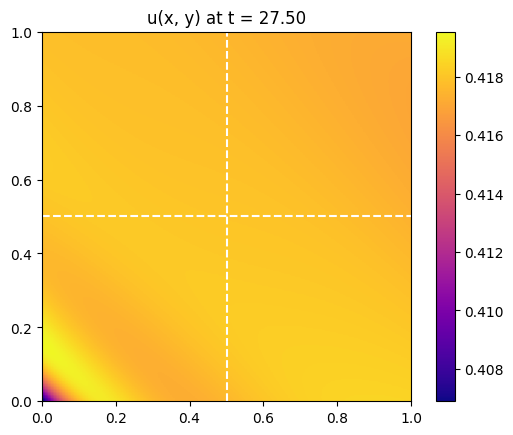

RHS max: 6.0486e-02, min: 2.1870e-02, mean: 2.7026e-02
iter: 56 ###############################
    Epoch [150/1500], Loss: -0.01156248
    Epoch [300/1500], Loss: -0.01156248
    Epoch [450/1500], Loss: -0.01156249
    Epoch [600/1500], Loss: -0.01156249
    Epoch [750/1500], Loss: -0.01156249
    Epoch [900/1500], Loss: -0.01156249
    Epoch [1050/1500], Loss: -0.01156250
    Epoch [1200/1500], Loss: -0.01156250
    Epoch [1350/1500], Loss: -0.01156190
    Epoch [1500/1500], Loss: -0.01156249
    Energy after iteration 56: 0.174347


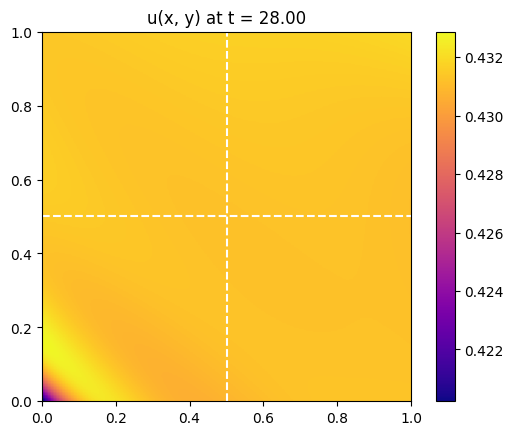

RHS max: 1.9794e-02, min: -1.8660e-02, mean: -1.3969e-02
iter: 57 ###############################
    Epoch [150/1500], Loss: 0.00606048
    Epoch [300/1500], Loss: 0.00606047
    Epoch [450/1500], Loss: 0.00606047
    Epoch [600/1500], Loss: 0.00606047
    Epoch [750/1500], Loss: 0.00606047
    Epoch [900/1500], Loss: 0.00606046
    Epoch [1050/1500], Loss: 0.00606046
    Epoch [1200/1500], Loss: 0.00606046
    Epoch [1350/1500], Loss: 0.00606045
    Epoch [1500/1500], Loss: 0.00606045
    Energy after iteration 57: 0.186050


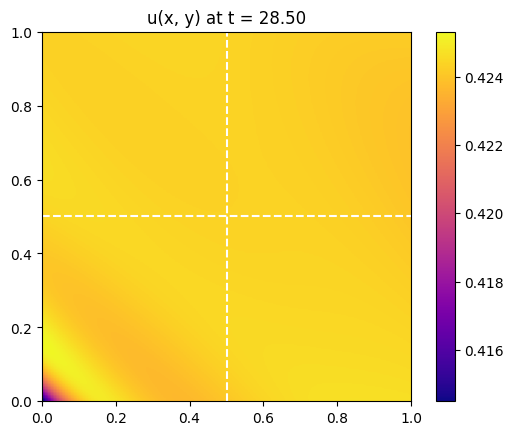

RHS max: 3.7284e-02, min: 4.2830e-03, mean: 7.3250e-03
iter: 58 ###############################
    Epoch [150/1500], Loss: -0.00313559
    Epoch [300/1500], Loss: -0.00313559
    Epoch [450/1500], Loss: -0.00313559
    Epoch [600/1500], Loss: -0.00313559
    Epoch [750/1500], Loss: -0.00313559
    Epoch [900/1500], Loss: -0.00313559
    Epoch [1050/1500], Loss: -0.00313559
    Epoch [1200/1500], Loss: -0.00313559
    Epoch [1350/1500], Loss: -0.00313560
    Epoch [1500/1500], Loss: -0.00313560
    Energy after iteration 58: 0.180025


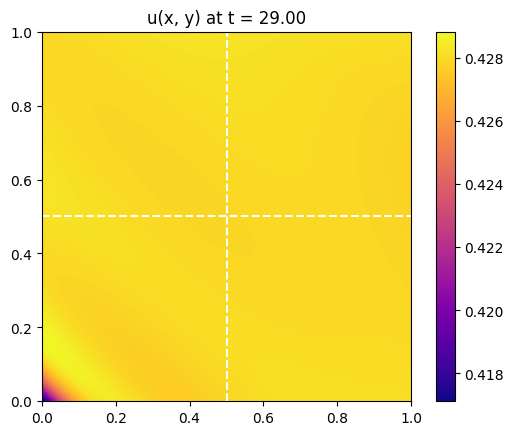

RHS max: 2.9276e-02, min: -6.4077e-03, mean: -3.8491e-03
iter: 59 ###############################
    Epoch [150/1500], Loss: 0.00162453
    Epoch [300/1500], Loss: 0.00162452
    Epoch [450/1500], Loss: 0.00162451
    Epoch [600/1500], Loss: 0.00162451
    Epoch [750/1500], Loss: 0.00162450
    Epoch [900/1500], Loss: 0.00162450
    Epoch [1050/1500], Loss: 0.00162449
    Epoch [1200/1500], Loss: 0.00162449
    Epoch [1350/1500], Loss: 0.00162449
    Epoch [1500/1500], Loss: 0.00162448
    Energy after iteration 59: 0.183163


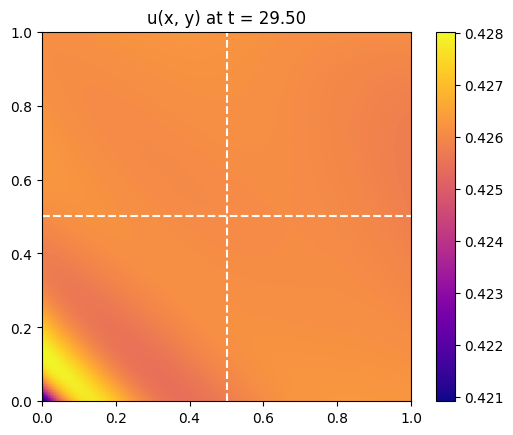

RHS max: 1.7717e-02, min: -3.9438e-03, mean: 1.9507e-03
iter: 60 ###############################
    Epoch [150/1500], Loss: -0.00085216
    Epoch [300/1500], Loss: -0.00085216
    Epoch [450/1500], Loss: -0.00085216
    Epoch [600/1500], Loss: -0.00085216
    Epoch [750/1500], Loss: -0.00085216
    Epoch [900/1500], Loss: -0.00085216
    Epoch [1050/1500], Loss: -0.00085216
    Epoch [1200/1500], Loss: -0.00085217
    Epoch [1350/1500], Loss: -0.00085217
    Epoch [1500/1500], Loss: -0.00085217
    Energy after iteration 60: 0.181536


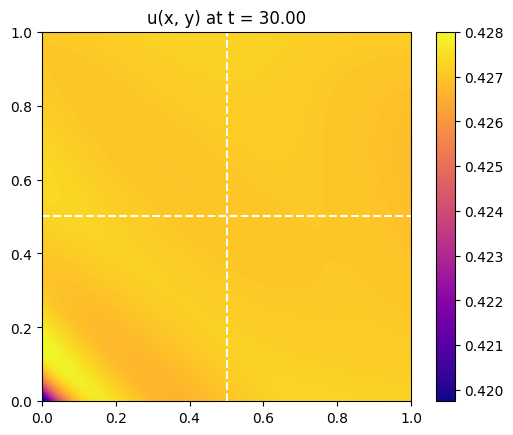

RHS max: 2.1264e-02, min: -3.8800e-03, mean: -1.1155e-03


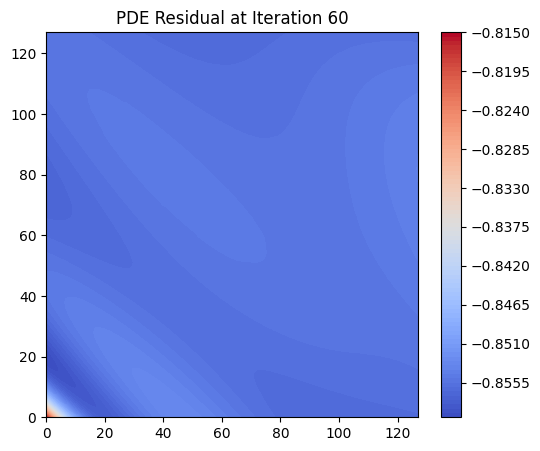

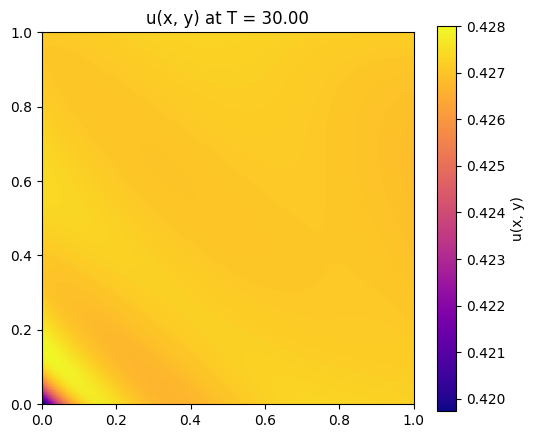

iter: 61 ###############################
    Epoch [150/1500], Loss: 0.00044601
    Epoch [300/1500], Loss: 0.00044600
    Epoch [450/1500], Loss: 0.00044600
    Epoch [600/1500], Loss: 0.00044600
    Epoch [750/1500], Loss: 0.00044600
    Epoch [900/1500], Loss: 0.00044600
    Epoch [1050/1500], Loss: 0.00044600
    Epoch [1200/1500], Loss: 0.00044600
    Epoch [1350/1500], Loss: 0.00044600
    Epoch [1500/1500], Loss: 0.00044600
    Energy after iteration 61: 0.182390


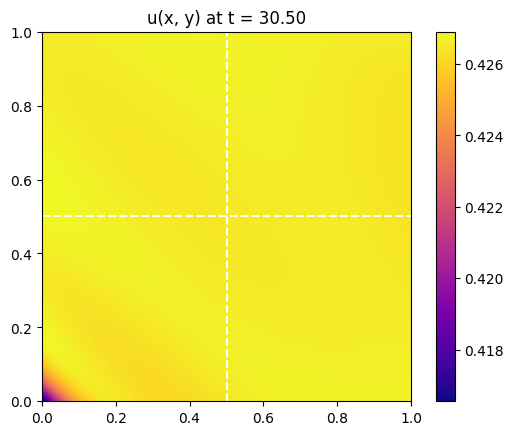

RHS max: 3.0997e-02, min: -5.4389e-04, mean: 5.0283e-04
iter: 62 ###############################
    Epoch [150/1500], Loss: -0.00022578
    Epoch [300/1500], Loss: -0.00022578
    Epoch [450/1500], Loss: -0.00022578
    Epoch [600/1500], Loss: -0.00022578
    Epoch [750/1500], Loss: -0.00022578
    Epoch [900/1500], Loss: -0.00022578
    Epoch [1050/1500], Loss: -0.00022578
    Epoch [1200/1500], Loss: -0.00022578
    Epoch [1350/1500], Loss: -0.00022578
    Epoch [1500/1500], Loss: -0.00022578
    Energy after iteration 62: 0.181948


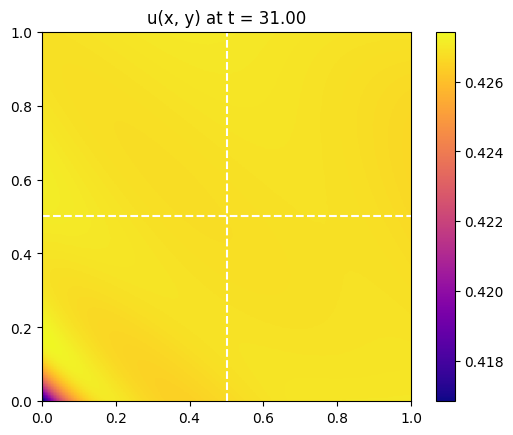

RHS max: 3.0126e-02, min: -2.1296e-03, mean: -3.0541e-04
iter: 63 ###############################
    Epoch [150/1500], Loss: 0.00010380
    Epoch [300/1500], Loss: 0.00010378
    Epoch [450/1500], Loss: 0.00010378
    Epoch [600/1500], Loss: 0.00010377
    Epoch [750/1500], Loss: 0.00010376
    Epoch [900/1500], Loss: 0.00010375
    Epoch [1050/1500], Loss: 0.00010375
    Epoch [1200/1500], Loss: 0.00010374
    Epoch [1350/1500], Loss: 0.00010374
    Epoch [1500/1500], Loss: 0.00010373
    Energy after iteration 63: 0.182165


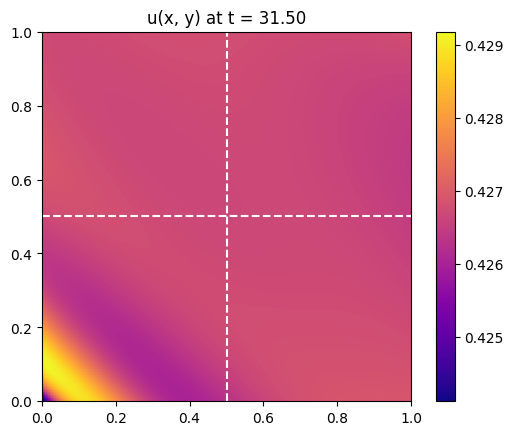

RHS max: 7.9618e-03, min: -7.4709e-03, mean: 8.7372e-05
iter: 64 ###############################
    Epoch [150/1500], Loss: -0.00005294
    Epoch [300/1500], Loss: -0.00005295
    Epoch [450/1500], Loss: -0.00005295
    Epoch [600/1500], Loss: -0.00005296
    Epoch [750/1500], Loss: -0.00005296
    Epoch [900/1500], Loss: -0.00005296
    Epoch [1050/1500], Loss: -0.00005297
    Epoch [1200/1500], Loss: -0.00005297
    Epoch [1350/1500], Loss: -0.00005297
    Epoch [1500/1500], Loss: -0.00005297
    Energy after iteration 64: 0.182062


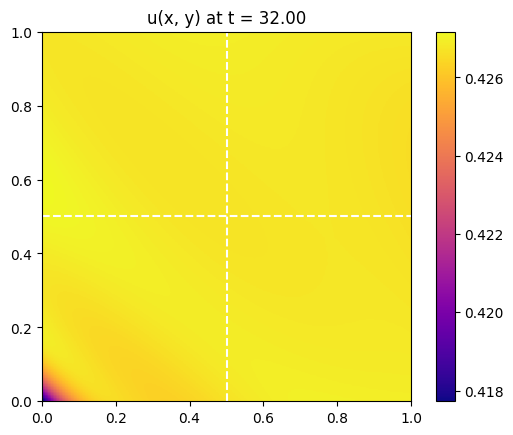

RHS max: 2.7414e-02, min: -1.3359e-03, mean: -9.5619e-05
iter: 65 ###############################
    Epoch [150/1500], Loss: 0.00002862
    Epoch [300/1500], Loss: 0.00002862
    Epoch [450/1500], Loss: 0.00002862
    Epoch [600/1500], Loss: 0.00002862
    Epoch [750/1500], Loss: 0.00002862
    Epoch [900/1500], Loss: 0.00002862
    Epoch [1050/1500], Loss: 0.00002862
    Epoch [1200/1500], Loss: 0.00002862
    Epoch [1350/1500], Loss: 0.00002862
    Epoch [1500/1500], Loss: 0.00002862
    Energy after iteration 65: 0.182116


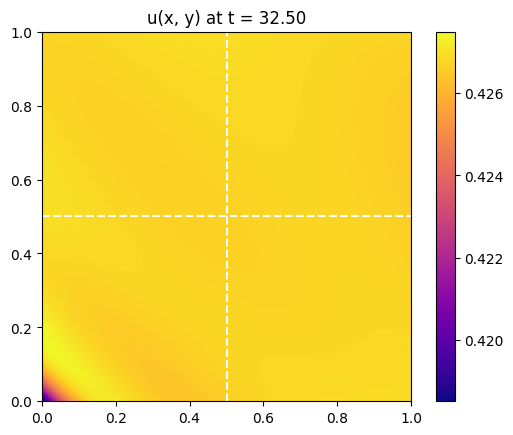

RHS max: 2.5064e-02, min: -2.3472e-03, mean: -4.4545e-05
iter: 66 ###############################
    Epoch [150/1500], Loss: -0.00002076
    Epoch [300/1500], Loss: -0.00002077
    Epoch [450/1500], Loss: -0.00002077
    Epoch [600/1500], Loss: -0.00002077
    Epoch [750/1500], Loss: -0.00002077
    Epoch [900/1500], Loss: -0.00002077
    Epoch [1050/1500], Loss: -0.00002077
    Epoch [1200/1500], Loss: -0.00002077
    Epoch [1350/1500], Loss: -0.00002077
    Epoch [1500/1500], Loss: -0.00002078
    Energy after iteration 66: 0.182083


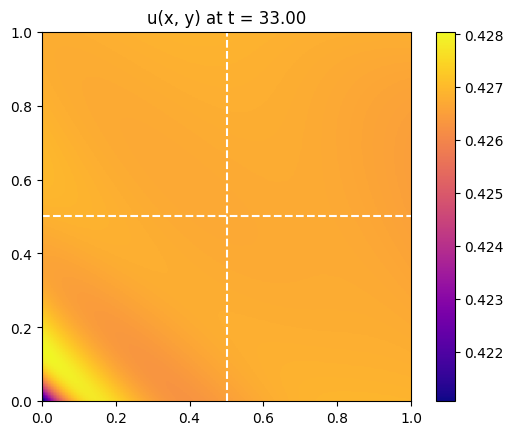

RHS max: 1.7242e-02, min: -4.0219e-03, mean: -7.2244e-05
iter: 67 ###############################
    Epoch [150/1500], Loss: 0.00001826
    Epoch [300/1500], Loss: 0.00001825
    Epoch [450/1500], Loss: 0.00001825
    Epoch [600/1500], Loss: 0.00001825
    Epoch [750/1500], Loss: 0.00001825
    Epoch [900/1500], Loss: 0.00001825
    Epoch [1050/1500], Loss: 0.00001825
    Epoch [1200/1500], Loss: 0.00001825
    Epoch [1350/1500], Loss: 0.00001825
    Epoch [1500/1500], Loss: 0.00001825
    Energy after iteration 67: 0.182109


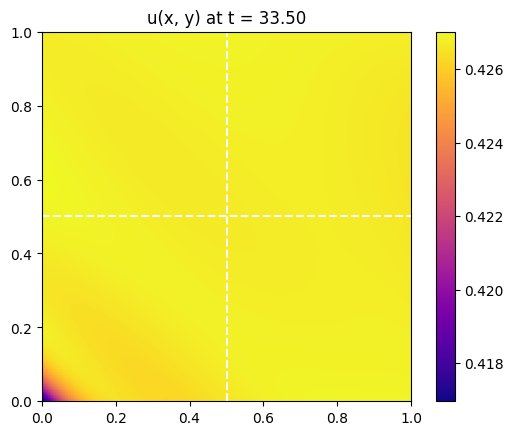

RHS max: 2.9745e-02, min: -8.6957e-04, mean: 6.7375e-05
iter: 68 ###############################
    Epoch [150/1500], Loss: -0.00002153
    Epoch [300/1500], Loss: -0.00002154
    Epoch [450/1500], Loss: -0.00002154
    Epoch [600/1500], Loss: -0.00002154
    Epoch [750/1500], Loss: -0.00002154
    Epoch [900/1500], Loss: -0.00002154
    Epoch [1050/1500], Loss: -0.00002155
    Epoch [1200/1500], Loss: -0.00002155
    Epoch [1350/1500], Loss: -0.00002155
    Epoch [1500/1500], Loss: -0.00002155
    Energy after iteration 68: 0.182083


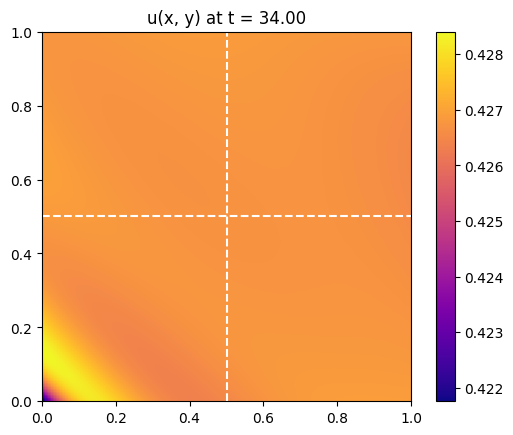

RHS max: 1.5123e-02, min: -5.1004e-03, mean: -1.0947e-04
iter: 69 ###############################
    Epoch [150/1500], Loss: 0.00001013
    Epoch [300/1500], Loss: 0.00001013
    Epoch [450/1500], Loss: 0.00001013
    Epoch [600/1500], Loss: 0.00001013
    Epoch [750/1500], Loss: 0.00001013
    Epoch [900/1500], Loss: 0.00001013
    Epoch [1050/1500], Loss: 0.00001013
    Epoch [1200/1500], Loss: 0.00001013
    Epoch [1350/1500], Loss: 0.00001013
    Epoch [1500/1500], Loss: 0.00001013
    Energy after iteration 69: 0.182104


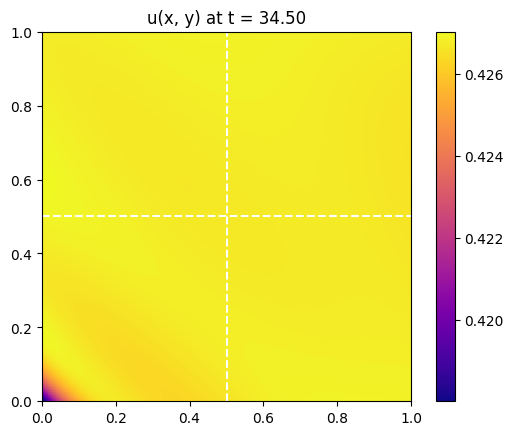

RHS max: 2.6576e-02, min: -9.3490e-04, mean: -3.3547e-06


In [14]:
tot_losses = [] 
energies = []
max_val = []
mean_val = []
min_val = []
u0_tensor = u_n.to(device)     

for n in range(int(N)):
    print(f"iter: {n} ###############################")

    if n == 0:
        ic_loss = u0_tensor
        points = xy_t.clone().detach()
    else:
        ic_loss = None
        points = sample_from_pools(full_pts, disease_pts, ic_pts, colloc_p, br_ic=0.2, br_disease=0.5)
    model, losses = train(deepRM, points, sigma_norm, rhs_norm, dt, lr, steps, device,
                      ic_target=ic_loss, full_grid=xy_t, u_n=torch.tensor(u_np.flatten(), dtype=torch.float32).to(device))

    tot_losses.extend(losses)

    u = model(points)
    grad_u = grad(model, points)
    grad_norm_sq = torch.sum(grad_u**2, dim=-1)
    diff = 0.5 * sigma_norm(points) * grad_norm_sq
    react = (0.5 / dt) * u**2
    src = rhs_norm(points) * u
    energy = (diff + react - src).mean()
    energies.append(energy)
    print(f"    Energy after iteration {n}: {energy.item():.6f}")

    with torch.no_grad():
           u_next = model(xy_t).squeeze().detach().cpu().numpy().reshape(n_x, n_y)

    u_n_prev = u_n.detach().cpu().numpy().reshape(n_x, n_y)
    
    fig, ax = plt.subplots()
    im = ax.imshow(u_next, origin='lower', extent=[0,1,0,1], cmap='plasma')
    plt.colorbar(im)
    ax.set_title(f"u(x, y) at t = {n * dt:.2f}")
    ax.axvline(x=0.5, color='white', linestyle='--')
    ax.axhline(y=0.5, color='white', linestyle='--')
    plt.show()
    

    u_n = torch.tensor(u_next.flatten(), dtype=torch.float32).to(device)
    u_np = u_next
    # u_n = u_pred.clone()
    # u_np = u_n.detach().cpu().numpy().reshape(n_x, n_y)
    rhs_v = rhs(u_np, a, fr, ft, fd, dt).flatten()
    rhs_t = torch.tensor(rhs_v, dtype=torch.float32).to(device)
    max_val.append(rhs_t.max().item())
    min_val.append(rhs_t.min().item())
    mean_val.append(rhs_t.mean().item())
    print(f"RHS max: {rhs_t.max():.4e}, min: {rhs_t.min():.4e}, mean: {rhs_t.mean():.4e}")

    graphs = stats(model, xy_t, u_n, sigma_norm, dt, a, fr, ft, fd)
    if n % 10 == 0:
        plt.figure(figsize=(6, 5))
        plt.contourf(graphs['residual'].reshape(n_x, n_y), levels=100, cmap='coolwarm')
        plt.colorbar()
        plt.title(f"PDE Residual at Iteration {n}")
        plt.show()
        
        plt.figure(figsize=(6, 5))
        plt.imshow(u_np, origin='lower', extent=[0,1,0,1], cmap='plasma')
        plt.colorbar(label='u(x, y)')
        plt.title(f"u(x, y) at T = {n*dt:.2f}")
        plt.show()

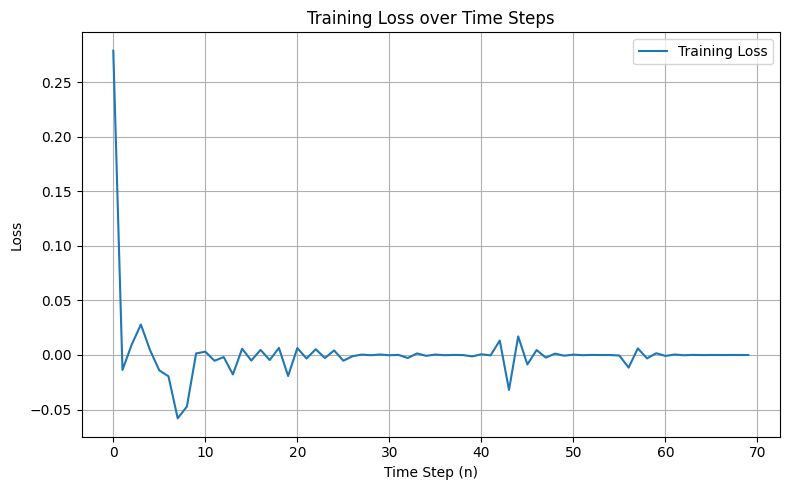

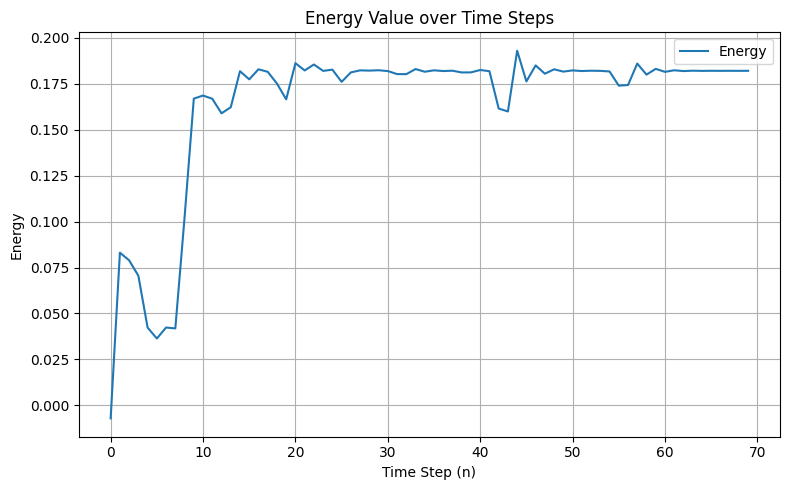

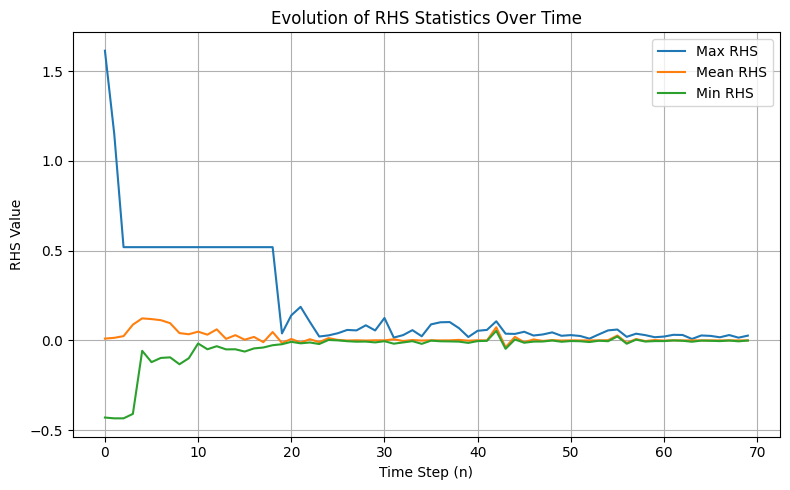

First 5 Energy values: [-0.007117724511772394, 0.0830855444073677, 0.07891938090324402, 0.07051730155944824, 0.04229513555765152]
First 5 Max RHS values: [1.6136736869812012, 1.1504592895507812, 0.519355058670044, 0.5193570256233215, 0.5193570256233215]
First 5 Mean RHS values: [0.009881231933832169, 0.014245949685573578, 0.02375704236328602, 0.08770077675580978, 0.12266309559345245]
First 5 Min RHS values: [-0.4298163652420044, -0.4342442750930786, -0.43424832820892334, -0.4094609022140503, -0.05810195207595825]


In [38]:
steps = 1500  
N = len(tot_losses) // steps 
nn = len(energies) // steps

# ---- Losses over time ----
losses_per_n = [tot_losses[i * steps + (steps - 1)] for i in range(N)]
x_loss = list(range(N))
plt.figure(figsize=(8, 5))
plt.plot(x_loss, losses_per_n, label='Training Loss')
plt.xlabel("Time Step (n)")
plt.ylabel("Loss")
plt.title("Training Loss over Time Steps")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ---- Energy over time ----
energy_per_n = [e.item() for e in energies]
x_vals = list(range(len(energy_per_n)))
x_energy = list(range(nn))
plt.figure(figsize=(8, 5))
plt.plot(x_vals, energy_per_n, label='Energy')
plt.xlabel("Time Step (n)")
plt.ylabel("Energy")
plt.title("Energy Value over Time Steps")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

x_max = list(range(len(max_val)))
x_min = list(range(len(min_val)))
x_mean = list(range(len(mean_val)))


plt.figure(figsize=(8, 5))
plt.plot(x_vals, max_val, label='Max RHS')       
plt.plot(x_vals, mean_val, label='Mean RHS')     
plt.plot(x_vals, min_val, label='Min RHS')       
plt.xlabel('Time Step (n)')
plt.ylabel('RHS Value')
plt.title('Evolution of RHS Statistics Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

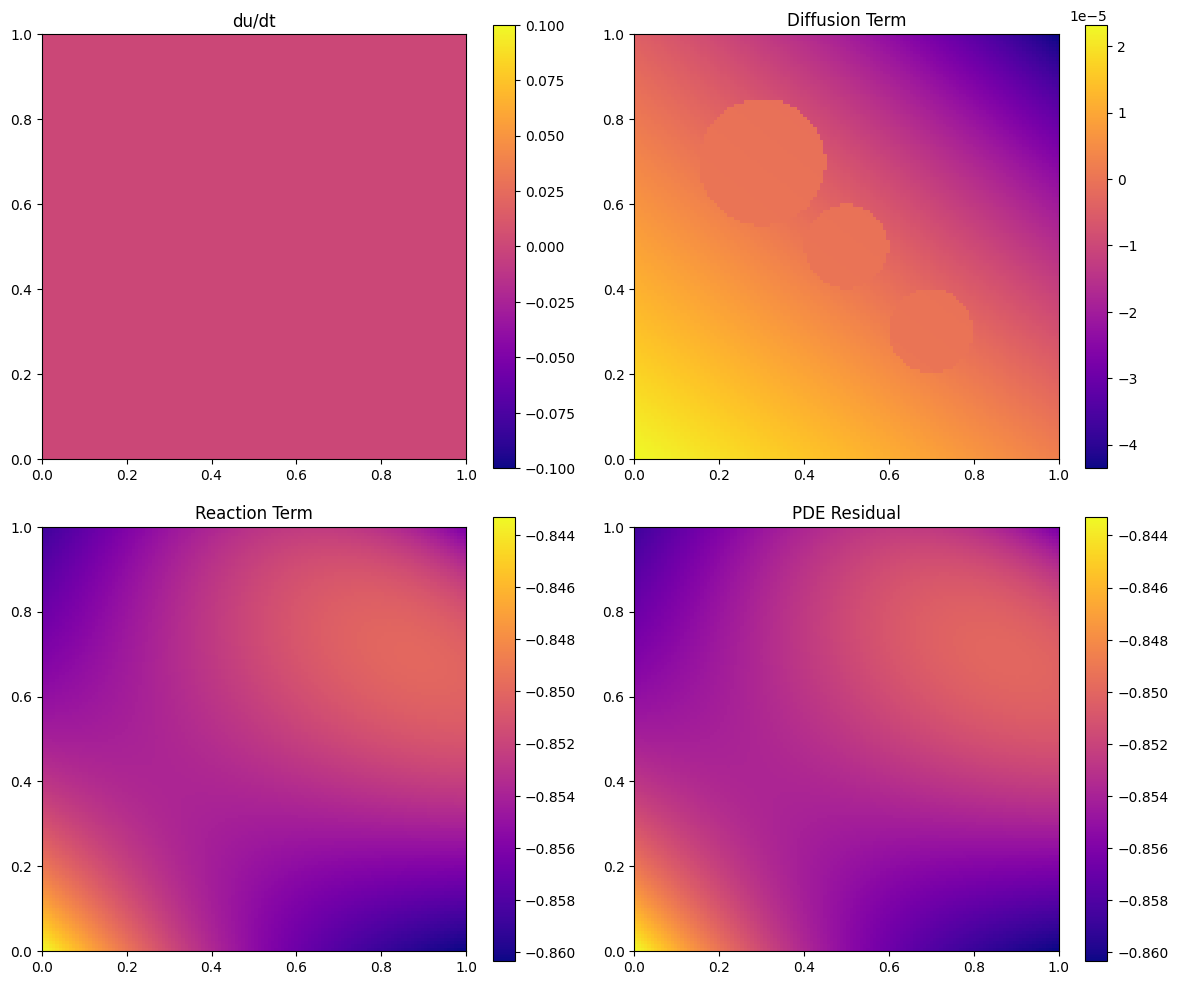

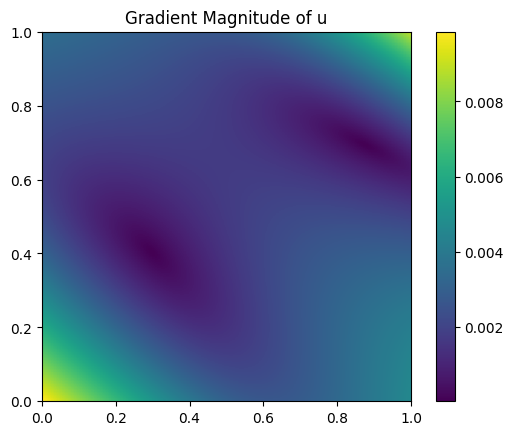

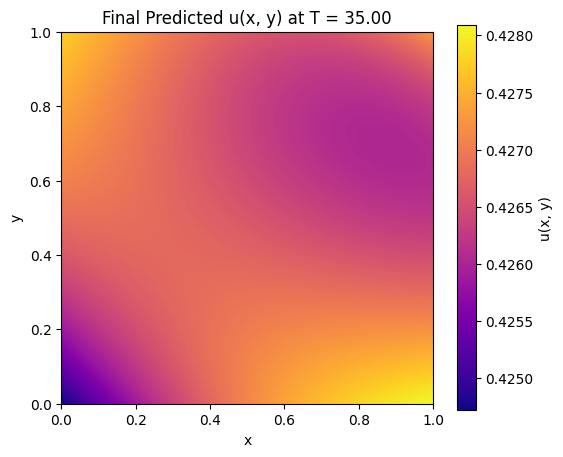

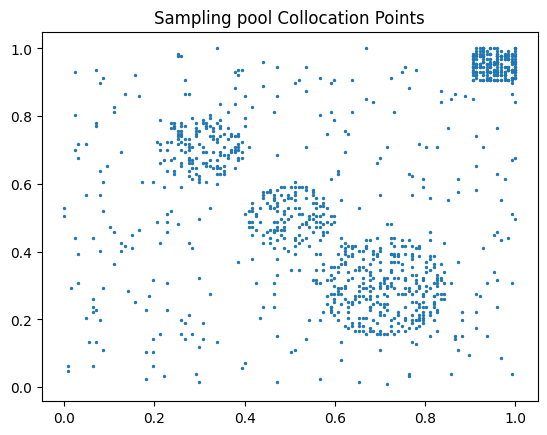

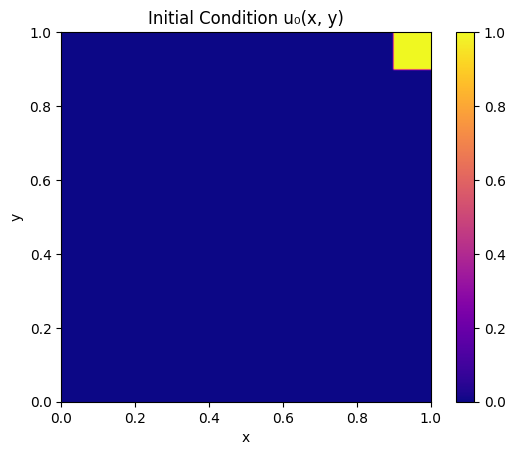

In [38]:
du_dt_map = graphs['du_dt'].reshape(n_x, n_y)
diff_map = graphs['diffusion'].reshape(n_x, n_y)
react_map = graphs['reaction'].reshape(n_x, n_y)
resid_map = graphs['residual'].reshape(n_x, n_y)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
titles = ['du/dt', 'Diffusion Term', 'Reaction Term', 'PDE Residual']
maps = [du_dt_map, diff_map, react_map, resid_map]

for ax, m, title in zip(axes.flat, maps, titles):
    im = ax.imshow(m, extent=[0, 1, 0, 1], origin='lower', cmap='plasma')
    ax.set_title(title)
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()


grad_mag = np.linalg.norm(graphs['grad_u'], axis=1).reshape(n_x, n_y)
plt.imshow(grad_mag, extent=[0,1,0,1], origin='lower')
plt.colorbar()
plt.title("Gradient Magnitude of u")
plt.show()

u_final = u_n.detach().cpu().numpy().reshape(n_x, n_y)

plt.figure(figsize=(6, 5))
plt.imshow(u_final, origin='lower', extent=[0,1,0,1], cmap='plasma')
plt.colorbar(label='u(x, y)')
plt.title('Final Predicted u(x, y) at T = {:.2f}'.format(N * dt))
plt.xlabel('x')
plt.ylabel('y')
plt.grid(False)
plt.show()

pts_np = points.detach().cpu().numpy()
plt.scatter(pts_np[:,0], pts_np[:,1], s=2)
plt.title("Sampling pool Collocation Points")
plt.show()

u0 = ic(n_x, n_y)
plt.imshow(u0, origin='lower', extent=[0,1,0,1], cmap='plasma')
plt.colorbar()
plt.title("Initial Condition u_0(x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()